In [ ]:
!pip install talib-binary

     |████████████████████████████████| 2.4 MB 5.0 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import talib
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans


# Data Manipulation

In [ ]:
#loading the file Historical_series.xlsx

xls = pd.ExcelFile("Historical_series.xlsx")

In [ ]:
#define the function to count the sequence of positive returns

def positivecounter(df):
    counter = []
    index = 0
    for i in df['pos_string']:
        if i == 1:
            index = index + 1
            counter.append(index)
        else:
            index = 0
            counter.append(index)
    df['count_pos_string'] = counter  

## IBM

In [ ]:
IBM = pd.read_excel(xls, "IBM", header=None).drop([0])
new_header=IBM.iloc[0]
IBM.columns=new_header
IBM=IBM[1:]
IBM=IBM.reset_index(drop=True)
IBM = IBM.loc[:, IBM.columns.notna()]
IBM = IBM.T.drop_duplicates().T
#GLD = GLD.iloc[:,0:4]
IBM.columns = ['Date', 'AdjClose', 'avg10', 'avg50']

ticker = 'IBM'
period1 = int(time.mktime(datetime.datetime(1999, 12, 31, 23, 59).timetuple())) #year,month,day,hour,minute
period2 = int(time.mktime(datetime.datetime(2022, 2, 11, 23, 59).timetuple()))
interval = '1d' # 1d, 1m, 1wk

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
ibmy = pd.read_csv(query_string)

ibmy = ibmy.dropna()
ibmy['Date'] = pd.to_datetime(ibmy['Date'])

IBM_final = pd.merge(IBM,ibmy,on='Date')

IBM_final["SPD_OPEN/CLOSE"] = (
    IBM_final["Close"] - IBM_final["Open"]
    )
IBM_final["SPD_HIGH/LOW"] = (
    IBM_final["High"] - IBM_final["Low"]
    )

#calculate the %ADJclose price variation of IBM stock

for i in IBM_final["AdjClose"]:
    IBM_final["Adj_Close_Returns"] = IBM_final["AdjClose"].pct_change()*100

for i in IBM_final["Close"]:
    IBM_final["Close_Returns"] = IBM_final["Close"].pct_change()*100

IBM_final['Log_Returns'] = np.log(IBM_final['AdjClose'].astype('float64')/IBM_final['AdjClose'].astype('float64').shift(1))


pd.to_datetime(IBM_final["Date"])
IBM_final=IBM_final.set_index("Date")

IBM_final['avg7'] = IBM_final["AdjClose"].rolling(window =7).mean()
IBM_final["avg10"] = IBM_final["AdjClose"].rolling(window =10).mean()
IBM_final["avg50"] = IBM_final["AdjClose"].rolling(window =50).mean()
IBM_final['avg100'] = IBM_final["AdjClose"].rolling(window =100).mean()
IBM_final["avg200"] = IBM_final["AdjClose"].rolling(window =200).mean()
IBM_final['avg253'] = IBM_final["AdjClose"].rolling(window =253).mean()

#POSITIVE AND NEGATIVE COUNTING 

pos_count_IBM, neg_count_IBM = 0, 0
  
# iterating each number in list
for num in IBM_final["Adj_Close_Returns"]:
      
    # checking condition
    if num >= 0:
        pos_count_IBM += 1
  
    else:
        neg_count_IBM += 1
          
print("Positive closing IBM: ", pos_count_IBM)
print("Negative closing IBM: ", neg_count_IBM)

Positive closing IBM:  2854
Negative closing IBM:  2712


In [ ]:
#AdjClose to BINARY

positive_string_IBM = []

for i in IBM_final["Adj_Close_Returns"]:
    if i > 0:
        positive_string_IBM.append(1)
    else:
        positive_string_IBM.append(0)
        
IBM_final["pos_string"] = positive_string_IBM

IBM_final = IBM_final.fillna(0)

IBM_final = IBM_final[['AdjClose','Open','High','Low','Close','Volume','avg7','avg10','avg50','avg100','avg200','avg253','SPD_OPEN/CLOSE','SPD_HIGH/LOW', "Adj_Close_Returns",'Close_Returns','Log_Returns','pos_string']]

IBM_final['direction'] = np.sign(IBM_final['Adj_Close_Returns']).astype(int)

positivecounter(IBM_final)

IBM_final


,AdjClose,Open,High,Low,Close,Volume,avg7,avg10,avg50,avg100,avg200,avg253,SPD_OPEN/CLOSE,SPD_HIGH/LOW,Adj_Close_Returns,Close_Returns,Log_Returns,pos_string,direction,count_pos_string
Date,,,,,,,,,,,,,,,,,,,,
1999-12-31,61.780476,104.385757,104.684509,101.935944,103.130974,3002334,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.254783,2.748565,0.000000,0.000000,0.000000,0,0,0
2000-01-03,66.433693,107.492828,110.898659,106.955070,110.898659,10823694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.405831,3.943589,7.531857,7.531864,0.072617,1,1,1
2000-01-04,64.178642,108.986618,109.464630,105.999046,107.134323,8606279,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.852295,3.465584,-3.394438,-3.394393,-0.034534,0,-1,0
2000-01-05,66.433693,107.970840,114.483749,107.194077,110.898659,13318927,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.927819,7.289672,3.513709,3.513660,0.034534,1,1,1
2000-01-06,65.288307,112.810707,113.706978,108.508606,108.986618,8338607,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.824089,5.198372,-1.724104,-1.724134,-0.017391,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-07,135.606552,137.449997,137.820007,136.270004,137.240005,3759000,134.525286,133.976187,128.115187,126.085076,129.005488,126.527303,-0.209992,1.550003,0.065632,0.065630,0.000656,1,1,1
2022-02-08,135.389175,137.229996,137.520004,135.779999,137.020004,4181800,134.881003,134.067093,128.534338,126.167161,129.037291,126.623015,-0.209992,1.740005,-0.160300,-0.160304,-0.001604,0,-1,0
2022-02-09,136.149994,137.839996,138.350006,136.830002,137.789993,5393500,135.476682,134.415891,128.915546,126.268040,129.070894,126.721302,-0.050003,1.520004,0.561949,0.561954,0.005604,1,1,1


In [ ]:
worst_IBM = IBM_final["Adj_Close_Returns"].loc["2010-01":"2015-01"].idxmin() #direi di fare cosi per diversi periodi di tempo per individuare i massimi e i minimi da sfruttare
best_IBM = IBM_final["Adj_Close_Returns"].idxmax()

std_IBM = IBM_final["Adj_Close_Returns"].std() 
avg_IBM = IBM_final["Adj_Close_Returns"].mean()

## NASDAQ

In [ ]:
NASDAQ = pd.read_excel(xls, "Nasdaq", header=None).drop([0])
new_header=NASDAQ.iloc[0]
NASDAQ.columns=new_header
NASDAQ=NASDAQ[1:]
NASDAQ=NASDAQ.reset_index(drop=True)
NASDAQ = NASDAQ.loc[:, NASDAQ.columns.notna()]
NASDAQ = NASDAQ.T.drop_duplicates().T
NASDAQ.columns = ['Date', 'AdjClose', 'avg10', 'avg50']

#Download gold daily data from yahoo database

ticker = '^IXIC'
period1 = int(time.mktime(datetime.datetime(1999, 12, 31, 23, 59).timetuple())) #year,month,day,hour,minute
period2 = int(time.mktime(datetime.datetime(2022, 2, 11, 23, 59).timetuple()))
interval = '1d' # 1d, 1m, 1wk

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

nsdqy = pd.read_csv(query_string)

#Clean goldy dataset

nsdqy = nsdqy.dropna()
nsdqy['Date'] = pd.to_datetime(nsdqy['Date'])

NASDAQ_final = pd.merge(NASDAQ,nsdqy,on='Date')

NASDAQ_final["SPD_OPEN/CLOSE"] = (
    NASDAQ_final["Close"] - NASDAQ_final["Open"]
    )
NASDAQ_final["SPD_HIGH/LOW"] = (
    NASDAQ_final["High"] - NASDAQ_final["Low"]
    )

#calculate the %price variation of NASDAQ stock
for i in NASDAQ_final["AdjClose"]:
    NASDAQ_final["Adj_Close_Returns"] = NASDAQ_final["AdjClose"].pct_change()*100

for i in NASDAQ_final["Close"]:
    NASDAQ_final["Close_Returns"] = NASDAQ_final["Close"].pct_change()*100

NASDAQ_final['Log_Returns'] = np.log(NASDAQ_final['AdjClose'].astype('float64')/NASDAQ_final['AdjClose'].astype('float64').shift(1))

pd.to_datetime(NASDAQ_final["Date"])
NASDAQ_final=NASDAQ_final.set_index("Date")


NASDAQ_final["avg7"] = NASDAQ_final["AdjClose"].rolling(window =7).mean()
NASDAQ_final["avg10"] = NASDAQ_final["AdjClose"].rolling(window =10).mean()
NASDAQ_final["avg50"] = NASDAQ_final["AdjClose"].rolling(window =50).mean()
NASDAQ_final["avg100"] = NASDAQ_final["AdjClose"].rolling(window =100).mean()
NASDAQ_final["avg200"] = NASDAQ_final["AdjClose"].rolling(window =200).mean()
NASDAQ_final["avg253"] = NASDAQ_final["AdjClose"].rolling(window =253).mean()

#POSITIVE AND NEGATIVE COUNTING 

pos_count_NASDAQ, neg_count_NASDAQ = 0, 0
  
# iterating each number in list
for num in NASDAQ_final["Adj_Close_Returns"]:
      
    # checking condition
    if num >= 0:
        pos_count_NASDAQ += 1
  
    else:
        neg_count_NASDAQ += 1
          
print("Positive closing IBM: ", pos_count_NASDAQ)
print("Negative closing IBM: ", neg_count_NASDAQ)

Positive closing IBM:  3030
Negative closing IBM:  2536


In [ ]:
positive_string_NASDAQ = []

for i in NASDAQ_final["Adj_Close_Returns"]:
    if i > 0:
        positive_string_NASDAQ.append(1)
    else:
        positive_string_NASDAQ.append(0)
        
NASDAQ_final["pos_string"] = positive_string_NASDAQ

NASDAQ_final = NASDAQ_final.fillna(0)

NASDAQ_final = NASDAQ_final[['AdjClose','Open','High','Low','Close','Volume','avg7','avg10','avg50','avg100','avg200','avg253','SPD_OPEN/CLOSE','SPD_HIGH/LOW', "Adj_Close_Returns",'Close_Returns','Log_Returns' ,'pos_string']]

NASDAQ_final['direction'] = np.sign(NASDAQ_final['Adj_Close_Returns']).astype(int)

positivecounter(NASDAQ_final)

NASDAQ_final

,AdjClose,Open,High,Low,Close,Volume,avg7,avg10,avg50,avg100,avg200,avg253,SPD_OPEN/CLOSE,SPD_HIGH/LOW,Adj_Close_Returns,Close_Returns,Log_Returns,pos_string,direction,count_pos_string
Date,,,,,,,,,,,,,,,,,,,,
1999-12-31,4069.310059,4056.989990,4082.370117,4032.330078,4069.310059,762980000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.320069,50.040039,0.000000,0.000000,0.000000,0,0,0
2000-01-03,4131.149902,4186.189941,4192.189941,3989.709961,4131.149902,1510070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-55.040039,202.479980,1.519664,1.519664,0.015082,1,1,1
2000-01-04,3901.689941,4020.000000,4073.250000,3898.229980,3901.689941,1511840000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-118.310059,175.020020,-5.554385,-5.554385,-0.057146,0,-1,0
2000-01-05,3877.540039,3854.350098,3924.209961,3734.870117,3877.540039,1735670000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.189941,189.339844,-0.618960,-0.618960,-0.006209,0,-1,0
2000-01-06,3727.129883,3834.439941,3868.760010,3715.620117,3727.129883,1598320000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-107.310058,153.139893,-3.879010,-3.879010,-0.039562,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-07,14015.669922,14118.790039,14236.309570,13974.099609,14015.669922,4253020000,14109.500000,13920.069043,14972.665566,15095.545977,14735.098687,14483.147295,-103.120117,262.209961,-0.584053,-0.584053,-0.005858,0,-1,0
2022-02-08,14194.450195,13984.429688,14226.480469,13934.780273,14194.450195,4277150000,14170.054269,13985.585059,14946.721367,15085.671279,14735.377036,14483.964728,210.020507,291.700196,1.275574,1.275574,0.012675,1,1,1
2022-02-09,14490.370117,14368.160156,14490.719727,14330.870117,14490.370117,4713210000,14205.838588,14080.410059,14920.872168,15080.135283,14737.377788,14485.872514,122.209961,159.849610,2.084758,2.084758,0.020633,1,1,2


In [ ]:
worst_NASDAQ = NASDAQ_final["Adj_Close_Returns"].loc["2010-01":"2015-01"].idxmin()
best_NASDAQ = NASDAQ_final["Adj_Close_Returns"].idxmax()

std_NASDAQ = NASDAQ_final["Adj_Close_Returns"].std() 
avg_NASDAQ = NASDAQ_final["Adj_Close_Returns"].mean()

## GOLD

In [ ]:

#sheet Gold with daily data

GLD = pd.read_excel(xls, "Gold", header=None).drop([0])
new_header=GLD.iloc[0]
GLD.columns=new_header
GLD=GLD[1:]
GLD=GLD.reset_index(drop=True)
GLD = GLD.loc[:, GLD.columns.notna()]
GLD = GLD.T.drop_duplicates().T
GLD = GLD.iloc[:,0:4]
GLD.columns = ['Date', 'AdjClose', 'avg10', 'avg50']

#Download gold daily data from yahoo database

ticker = 'GC=F'
period1 = int(time.mktime(datetime.datetime(2000, 8, 30, 23, 59).timetuple())) #year,month,day,hour,minute
period2 = int(time.mktime(datetime.datetime(2022, 2, 11, 23, 59).timetuple()))
interval = '1d' # 1d, 1m, 1wk

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

goldy = pd.read_csv(query_string)

#Clean goldy dataset

goldy = goldy.dropna()
goldy['Date'] = pd.to_datetime(goldy['Date'])

#merging the two dataset

GLD_final = pd.merge(GLD,goldy,on='Date')

#Cleaning of GLD_final

GLD_final = GLD_final.drop(GLD_final.columns[8],axis=1)
GLD_final = GLD_final.set_index('Date')

#Adding avarage mean 7,100,200,253 days
GLD_final["avg7"] = GLD_final["AdjClose"].rolling(window =7).mean()
GLD_final["avg100"] = GLD_final["AdjClose"].rolling(window =100).mean()
GLD_final["avg200"] = GLD_final["AdjClose"].rolling(window =200).mean()
GLD_final["avg253"] = GLD_final["AdjClose"].rolling(window =253).mean()

#adding SPD_OPEN/CLOSE, SPD_HIGH/LOW and %price variation on gold commodity
GLD_final["SPD_OPEN/CLOSE"] = (GLD_final['Close'] - GLD_final['Open'])

GLD_final['SPD_HIGH/LOW'] = (GLD_final['High']-GLD_final['Low'])


for i in GLD_final["AdjClose"]:
    GLD_final["Adj_Close_Returns"] = GLD_final["AdjClose"].pct_change()*100

for i in GLD_final["Close"]:
    GLD_final["Close_Returns"] = GLD_final["Close"].pct_change()*100

GLD_final['Log_Returns'] = np.log(GLD_final['AdjClose'].astype('float64')/GLD_final['AdjClose'].astype('float64').shift(1))
                              
#Positive and negative counting

pos_count_GLD, neg_count_GLD = 0,0

for num in GLD_final['Adj_Close_Returns']:
    if num >= 0:
        pos_count_GLD += 1
    else:
        neg_count_GLD += 1

print(f"Positive closing gold: {pos_count_GLD}")
print(f"Negative closing gold: {neg_count_GLD}")

Positive closing gold: 2835
Negative closing gold: 2507


In [ ]:
#AdjClose to binary

positive_string_GLD = []

for i in GLD_final['Adj_Close_Returns']:
    if i > 0:
        positive_string_GLD.append(1)
    else:
        positive_string_GLD.append(0)

GLD_final['pos_string'] = positive_string_GLD

GLD_final = GLD_final.fillna(0)

GLD_final = GLD_final[['AdjClose','Open','High','Low','Close','Volume','avg7','avg10','avg50','avg100','avg200','avg253','SPD_OPEN/CLOSE','SPD_HIGH/LOW', "Adj_Close_Returns",'Close_Returns','Log_Returns','pos_string']]

GLD_final['direction'] = np.sign(GLD_final['Adj_Close_Returns']).astype(int)

positivecounter(GLD_final)

GLD_final

,AdjClose,Open,High,Low,Close,Volume,avg7,avg10,avg50,avg100,avg200,avg253,SPD_OPEN/CLOSE,SPD_HIGH/LOW,Adj_Close_Returns,Close_Returns,Log_Returns,pos_string,direction,count_pos_string
Date,,,,,,,,,,,,,,,,,,,,
2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0
2000-08-31,278.299988,274.799988,278.299988,274.799988,278.299988,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.500000,3.500000,1.606424,1.606424,0.015937,1,1,1
2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.467117,-0.467118,-0.004682,0,-1,0
2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.433217,-0.433217,-0.004342,0,-1,0
2000-09-06,274.200012,274.200012,274.200012,274.200012,274.200012,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.580122,-0.580122,-0.005818,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-07,1820.599976,1812.199951,1821.300049,1809.099976,1820.599976,601.0,1802.799997,1809.550000,1802.333994,1796.047992,1805.078495,1793.607902,8.400025,12.200073,0.774936,0.774936,0.007719,1,1,2
2022-02-08,1826.599976,1818.900024,1827.599976,1815.000000,1826.599976,108.0,1808.757132,1806.940002,1803.159993,1796.819991,1805.321495,1793.573514,7.699952,12.599976,0.329562,0.329562,0.003290,1,1,3
2022-02-09,1835.199951,1825.400024,1835.199951,1825.300049,1835.199951,683.0,1814.499983,1807.469995,1804.217991,1797.553990,1805.631495,1793.552170,9.799927,9.899902,0.470819,0.470819,0.004697,1,1,4


In [ ]:
worst_GLD = GLD_final["Adj_Close_Returns"].loc["2010-01":"2015-01"].idxmin()
best_GLD = GLD_final["Adj_Close_Returns"].idxmax()

std_GLD = GLD_final["Adj_Close_Returns"].std() 
avg_GLD = GLD_final["Adj_Close_Returns"].mean()

## WTI

In [ ]:
#sheet WTI with daily data

WTI = pd.read_excel(xls, "WTI", header=None).drop([0])
new_header=WTI.iloc[0]
WTI.columns=new_header
WTI=WTI[1:]
WTI=WTI.reset_index(drop=True)
WTI = WTI.loc[:, WTI.columns.notna()]
WTI = WTI.T.drop_duplicates().T
WTI = WTI.iloc[:,0:4]
WTI.columns = ['Date', 'AdjClose', 'avg10', 'avg50']

#Download WTI daily data from yahoo database

ticker = 'CL=F'
period1 = int(time.mktime(datetime.datetime(2000, 8, 23, 23, 59).timetuple())) #year,month,day,hour,minute
period2 = int(time.mktime(datetime.datetime(2022, 2, 11, 23, 59).timetuple()))
interval = '1d' # 1d, 1m, 1wk

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

wtiy = pd.read_csv(query_string)

#Clean wtly dataset

wtiy = wtiy.dropna()
wtiy['Date'] = pd.to_datetime(wtiy['Date'])

#merging the two dataset

WTI_final = pd.merge(WTI,wtiy,on='Date')

#Cleaning of WTI_final

WTI_final = WTI_final.drop(WTI_final.columns[8],axis=1)
WTI_final = WTI_final.set_index('Date')

#Adding avarage mean 7,100,200,253 days
WTI_final["avg7"] = WTI_final["AdjClose"].rolling(window =7).mean()
WTI_final["avg100"] = WTI_final["AdjClose"].rolling(window =100).mean()
WTI_final["avg200"] = WTI_final["AdjClose"].rolling(window =200).mean()
WTI_final["avg253"] = WTI_final["AdjClose"].rolling(window =253).mean()

#adding SPD_OPEN/CLOSE, SPD_HIGH/LOW and %price variation on gold commodity
WTI_final["SPD_OPEN/CLOSE"] = (WTI_final['Close'] - WTI_final['Open'])

WTI_final['SPD_HIGH/LOW'] = (WTI_final['High']-WTI_final['Low'])


for i in WTI_final["AdjClose"]:
    WTI_final["Adj_Close_Returns"] = WTI_final["AdjClose"].pct_change()*100

for i in WTI_final["Close"]:
    WTI_final["Close_Returns"] = WTI_final["Close"].pct_change()*100

WTI_final['Log_Returns'] = np.log(WTI_final['AdjClose'].astype('float64')/WTI_final['AdjClose'].astype('float64').shift(1))

#Positive and negative counting

pos_count_WTI, neg_count_WTI = 0,0

for num in WTI_final['Adj_Close_Returns']:
    if num >= 0:
        pos_count_WTI += 1
    else:
        neg_count_WTI += 1

print(f"Positive closing gold: {pos_count_WTI}")
print(f"Negative closing gold: {neg_count_WTI}")

Positive closing gold: 2833
Negative closing gold: 2559


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
#AdjClose to binary

positive_string_WTI = []

for i in WTI_final['Adj_Close_Returns']:
    if i > 0:
        positive_string_WTI.append(1)
    else:
        positive_string_WTI.append(0)

WTI_final['pos_string'] = positive_string_WTI

WTI_final = WTI_final.fillna(0)

WTI_final = WTI_final[['AdjClose','Open','High','Low','Close','Volume','avg7','avg10','avg50','avg100','avg200','avg253','SPD_OPEN/CLOSE','SPD_HIGH/LOW', "Adj_Close_Returns",'Close_Returns','Log_Returns', "pos_string"]]

WTI_final['direction'] = np.sign(WTI_final['Adj_Close_Returns']).astype(int)

positivecounter(WTI_final)

WTI_final

,AdjClose,Open,High,Low,Close,Volume,avg7,avg10,avg50,avg100,avg200,avg253,SPD_OPEN/CLOSE,SPD_HIGH/LOW,Adj_Close_Returns,Close_Returns,Log_Returns,pos_string,direction,count_pos_string
Date,,,,,,,,,,,,,,,,,,,,
2000-08-23,32.049999,31.950001,32.799999,31.950001,32.049999,79385.0,0.000000,0.000000,0.0000,0.0000,0.00000,0.000000,0.099998,0.849998,0.000000,0.000000,0.000000,0,0,0
2000-08-24,31.629999,31.900000,32.240002,31.400000,31.629999,72978.0,0.000000,0.000000,0.0000,0.0000,0.00000,0.000000,-0.270001,0.840002,-1.310453,-1.310452,-0.013191,0,-1,0
2000-08-25,32.049999,31.700001,32.099998,31.320000,32.049999,44601.0,0.000000,0.000000,0.0000,0.0000,0.00000,0.000000,0.349998,0.779998,1.327854,1.327853,0.013191,1,1,1
2000-08-28,32.869999,32.040001,32.919998,31.860001,32.869999,46770.0,0.000000,0.000000,0.0000,0.0000,0.00000,0.000000,0.829998,1.059997,2.558501,2.558502,0.025263,1,1,2
2000-08-29,32.720001,32.820000,33.029999,32.560001,32.720001,49131.0,0.000000,0.000000,0.0000,0.0000,0.00000,0.000000,-0.099999,0.469998,-0.456336,-0.456337,-0.004574,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-07,91.320000,91.820000,92.730003,90.730003,91.320000,497754.0,89.332856,88.488999,77.8280,78.5549,73.81990,71.247826,-0.500000,2.000000,-1.072471,-1.072471,-0.010783,0,-1,0
2022-02-08,89.360001,91.639999,91.680000,88.510002,89.360001,467386.0,89.695714,88.864999,78.2522,78.7288,73.95200,71.370356,-2.279998,3.169998,-2.146298,-2.146298,-0.021697,0,-1,0
2022-02-09,89.660004,89.860001,90.580002,88.410004,89.660004,445618.0,89.911428,89.096000,78.6464,78.9225,74.08100,71.492807,-0.199997,2.169998,0.335724,0.335724,0.003352,1,1,1


In [ ]:
worst_WTI = WTI_final["Adj_Close_Returns"].loc["2010-01":"2015-01"].idxmin()
best_WTI = WTI_final["Adj_Close_Returns"].idxmax()

std_WTI = WTI_final["Adj_Close_Returns"].std() 
avg_WTI = WTI_final["Adj_Close_Returns"].mean()

# Datasets

In [ ]:
IBM_final

,AdjClose,Open,High,Low,Close,Volume,avg7,avg10,avg50,avg100,avg200,avg253,SPD_OPEN/CLOSE,SPD_HIGH/LOW,Adj_Close_Returns,Close_Returns,Log_Returns,pos_string,direction,count_pos_string
Date,,,,,,,,,,,,,,,,,,,,
1999-12-31,61.780476,104.385757,104.684509,101.935944,103.130974,3002334,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.254783,2.748565,0.000000,0.000000,0.000000,0,0,0
2000-01-03,66.433693,107.492828,110.898659,106.955070,110.898659,10823694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.405831,3.943589,7.531857,7.531864,0.072617,1,1,1
2000-01-04,64.178642,108.986618,109.464630,105.999046,107.134323,8606279,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.852295,3.465584,-3.394438,-3.394393,-0.034534,0,-1,0
2000-01-05,66.433693,107.970840,114.483749,107.194077,110.898659,13318927,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.927819,7.289672,3.513709,3.513660,0.034534,1,1,1
2000-01-06,65.288307,112.810707,113.706978,108.508606,108.986618,8338607,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.824089,5.198372,-1.724104,-1.724134,-0.017391,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-07,135.606552,137.449997,137.820007,136.270004,137.240005,3759000,134.525286,133.976187,128.115187,126.085076,129.005488,126.527303,-0.209992,1.550003,0.065632,0.065630,0.000656,1,1,1
2022-02-08,135.389175,137.229996,137.520004,135.779999,137.020004,4181800,134.881003,134.067093,128.534338,126.167161,129.037291,126.623015,-0.209992,1.740005,-0.160300,-0.160304,-0.001604,0,-1,0
2022-02-09,136.149994,137.839996,138.350006,136.830002,137.789993,5393500,135.476682,134.415891,128.915546,126.268040,129.070894,126.721302,-0.050003,1.520004,0.561949,0.561954,0.005604,1,1,1


In [ ]:
NASDAQ_final

,AdjClose,Open,High,Low,Close,Volume,avg7,avg10,avg50,avg100,avg200,avg253,SPD_OPEN/CLOSE,SPD_HIGH/LOW,Adj_Close_Returns,Close_Returns,Log_Returns,pos_string,direction,count_pos_string
Date,,,,,,,,,,,,,,,,,,,,
1999-12-31,4069.310059,4056.989990,4082.370117,4032.330078,4069.310059,762980000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.320069,50.040039,0.000000,0.000000,0.000000,0,0,0
2000-01-03,4131.149902,4186.189941,4192.189941,3989.709961,4131.149902,1510070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-55.040039,202.479980,1.519664,1.519664,0.015082,1,1,1
2000-01-04,3901.689941,4020.000000,4073.250000,3898.229980,3901.689941,1511840000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-118.310059,175.020020,-5.554385,-5.554385,-0.057146,0,-1,0
2000-01-05,3877.540039,3854.350098,3924.209961,3734.870117,3877.540039,1735670000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.189941,189.339844,-0.618960,-0.618960,-0.006209,0,-1,0
2000-01-06,3727.129883,3834.439941,3868.760010,3715.620117,3727.129883,1598320000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-107.310058,153.139893,-3.879010,-3.879010,-0.039562,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-07,14015.669922,14118.790039,14236.309570,13974.099609,14015.669922,4253020000,14109.500000,13920.069043,14972.665566,15095.545977,14735.098687,14483.147295,-103.120117,262.209961,-0.584053,-0.584053,-0.005858,0,-1,0
2022-02-08,14194.450195,13984.429688,14226.480469,13934.780273,14194.450195,4277150000,14170.054269,13985.585059,14946.721367,15085.671279,14735.377036,14483.964728,210.020507,291.700196,1.275574,1.275574,0.012675,1,1,1
2022-02-09,14490.370117,14368.160156,14490.719727,14330.870117,14490.370117,4713210000,14205.838588,14080.410059,14920.872168,15080.135283,14737.377788,14485.872514,122.209961,159.849610,2.084758,2.084758,0.020633,1,1,2


In [ ]:
GLD_final

,AdjClose,Open,High,Low,Close,Volume,avg7,avg10,avg50,avg100,avg200,avg253,SPD_OPEN/CLOSE,SPD_HIGH/LOW,Adj_Close_Returns,Close_Returns,Log_Returns,pos_string,direction,count_pos_string
Date,,,,,,,,,,,,,,,,,,,,
2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0
2000-08-31,278.299988,274.799988,278.299988,274.799988,278.299988,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.500000,3.500000,1.606424,1.606424,0.015937,1,1,1
2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.467117,-0.467118,-0.004682,0,-1,0
2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.433217,-0.433217,-0.004342,0,-1,0
2000-09-06,274.200012,274.200012,274.200012,274.200012,274.200012,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.580122,-0.580122,-0.005818,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-07,1820.599976,1812.199951,1821.300049,1809.099976,1820.599976,601.0,1802.799997,1809.550000,1802.333994,1796.047992,1805.078495,1793.607902,8.400025,12.200073,0.774936,0.774936,0.007719,1,1,2
2022-02-08,1826.599976,1818.900024,1827.599976,1815.000000,1826.599976,108.0,1808.757132,1806.940002,1803.159993,1796.819991,1805.321495,1793.573514,7.699952,12.599976,0.329562,0.329562,0.003290,1,1,3
2022-02-09,1835.199951,1825.400024,1835.199951,1825.300049,1835.199951,683.0,1814.499983,1807.469995,1804.217991,1797.553990,1805.631495,1793.552170,9.799927,9.899902,0.470819,0.470819,0.004697,1,1,4


In [ ]:
WTI_final

,AdjClose,Open,High,Low,Close,Volume,avg7,avg10,avg50,avg100,avg200,avg253,SPD_OPEN/CLOSE,SPD_HIGH/LOW,Adj_Close_Returns,Close_Returns,Log_Returns,pos_string,direction,count_pos_string
Date,,,,,,,,,,,,,,,,,,,,
2000-08-23,32.049999,31.950001,32.799999,31.950001,32.049999,79385.0,0.000000,0.000000,0.0000,0.0000,0.00000,0.000000,0.099998,0.849998,0.000000,0.000000,0.000000,0,0,0
2000-08-24,31.629999,31.900000,32.240002,31.400000,31.629999,72978.0,0.000000,0.000000,0.0000,0.0000,0.00000,0.000000,-0.270001,0.840002,-1.310453,-1.310452,-0.013191,0,-1,0
2000-08-25,32.049999,31.700001,32.099998,31.320000,32.049999,44601.0,0.000000,0.000000,0.0000,0.0000,0.00000,0.000000,0.349998,0.779998,1.327854,1.327853,0.013191,1,1,1
2000-08-28,32.869999,32.040001,32.919998,31.860001,32.869999,46770.0,0.000000,0.000000,0.0000,0.0000,0.00000,0.000000,0.829998,1.059997,2.558501,2.558502,0.025263,1,1,2
2000-08-29,32.720001,32.820000,33.029999,32.560001,32.720001,49131.0,0.000000,0.000000,0.0000,0.0000,0.00000,0.000000,-0.099999,0.469998,-0.456336,-0.456337,-0.004574,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-07,91.320000,91.820000,92.730003,90.730003,91.320000,497754.0,89.332856,88.488999,77.8280,78.5549,73.81990,71.247826,-0.500000,2.000000,-1.072471,-1.072471,-0.010783,0,-1,0
2022-02-08,89.360001,91.639999,91.680000,88.510002,89.360001,467386.0,89.695714,88.864999,78.2522,78.7288,73.95200,71.370356,-2.279998,3.169998,-2.146298,-2.146298,-0.021697,0,-1,0
2022-02-09,89.660004,89.860001,90.580002,88.410004,89.660004,445618.0,89.911428,89.096000,78.6464,78.9225,74.08100,71.492807,-0.199997,2.169998,0.335724,0.335724,0.003352,1,1,1


In [ ]:

Dataset = [("avg",avg_IBM, avg_NASDAQ, avg_WTI, avg_GLD), ("std", std_IBM, std_NASDAQ, std_WTI, std_GLD)]

pd.DataFrame(Dataset)

pd.DataFrame(Dataset, columns = ["", "IBM", "NASDAQ", "WTI", "GLD"])


,,IBM,NASDAQ,WTI,GLD
0,avg,0.027559,0.034482,-0.014787,0.041846
1,std,1.661735,1.584392,5.224513,1.110652


In [ ]:
Dataset = [("avg",avg_IBM, avg_NASDAQ, avg_WTI, avg_GLD), ("std", std_IBM, std_NASDAQ, std_WTI, std_GLD)]

pd.DataFrame(Dataset)

Dataset = pd.DataFrame(Dataset, columns = ["", "IBM", "NASDAQ", "WTI", "GLD"])

Dataset= Dataset.transpose()
Dataset

,0,1
,avg,std
IBM,0.027559,1.661735
NASDAQ,0.034482,1.584392
WTI,-0.014787,5.224513
GLD,0.041846,1.110652


# Data Visualization

##ADJ close graphs

In [ ]:
#ADJ close Graph IBM

fig = px.line(IBM_final, x= IBM_final.index, y=IBM_final["AdjClose"], title = "Adjusted Closing Price")
fig.update_layout(hovermode = "x", yaxis_title= "Price")
fig.show()

In [ ]:
#NASDAQ

fig = px.line(NASDAQ_final, x= NASDAQ_final.index, y=NASDAQ_final["AdjClose"], title = "Adjusted Closing Price")
fig.update_layout(hovermode = "x", yaxis_title= "Price")
fig.show()

In [ ]:
#GOLD

fig = px.line(GLD_final, x= GLD_final.index, y=GLD_final["AdjClose"], title = "Adjusted Closing Price")
fig.update_layout(hovermode = "x", yaxis_title= "Price")
fig.show()

#QUA INVECE L'ASSE X E' GIUSTO DI NUOVO

In [ ]:
#WTI

fig = px.line(WTI_final, x= WTI_final.index, y=WTI_final["AdjClose"], title = "Adjusted Closing Price")
fig.update_layout(hovermode = "x", yaxis_title= "Price")
fig.show()


## ADJ close with crisis graphs

In [ ]:
#IBM

# read in data
rec_data = pd.read_csv("USREC.csv") # download the US recession periods from FRED.com

IBM_rec = IBM_final.iloc[:,0]
IBM_rec = pd.DataFrame(data=IBM_rec)
IBM_rec.reset_index(level=0, inplace=True)

rec_data['DATE'] = pd.to_datetime(rec_data['DATE'])

#enlarging data for data visualization
rec_data["USREC"] = np.where(rec_data['USREC']==1, 150 , 0) 

#resampling recession data to daily to keep it uniform with stock data
dy = rec_data.set_index('DATE').resample('D').ffill().reset_index()

fig, ax = plt.subplots()
IBM_rec.plot.line(ax=ax, figsize=(8, 5), x='Date', color="blue")
dy.plot.area(ax=ax, figsize=(8, 5), x='DATE', alpha=0.5, color="red")
plt.xlim("1999-01-01", "2022-01-01")

FileNotFoundError: ignored

In [ ]:
#NASDAQ

# read in data
rec_data = pd.read_csv("USREC.csv") # download the US recession periods from FRED.com

NASDAQ_rec = NASDAQ_final.iloc[:,0]
NASDAQ_rec = pd.DataFrame(data=NASDAQ_rec)
NASDAQ_rec.reset_index(level=0, inplace=True)

rec_data['DATE'] = pd.to_datetime(rec_data['DATE'])

#enlarging data for data visualization
rec_data["USREC"] = np.where(rec_data['USREC']==1, 16000 , 0) 

#resampling recession data to daily to keep it uniform with stock data
dy = rec_data.set_index('DATE').resample('D').ffill().reset_index()

fig, ax = plt.subplots()
NASDAQ_rec.plot.line(ax=ax, figsize=(8, 5), x='Date', color="blue")
dy.plot.area(ax=ax, figsize=(8, 5), x='DATE', alpha=0.5, color="red")
plt.xlim("1999-01-01", "2022-01-01")

In [ ]:
#GOLD

# read in data
rec_data = pd.read_csv("USREC.csv") # download the US recession periods from FRED.com

GLD_rec = GLD_final.iloc[:,0]
GLD_rec = pd.DataFrame(data=GLD_rec)
GLD_rec.reset_index(level=0, inplace=True)

rec_data['DATE'] = pd.to_datetime(rec_data['DATE'])

#enlarging data for data visualization
rec_data["USREC"] = np.where(rec_data['USREC']==1, 2050 , 0) 

#resampling recession data to daily to keep it uniform with stock data
dy = rec_data.set_index('DATE').resample('D').ffill().reset_index()

fig, ax = plt.subplots()
GLD_rec.plot.line(ax=ax, figsize=(8, 5), x='Date', color="blue")
dy.plot.area(ax=ax, figsize=(8, 5), x='DATE', alpha=0.5, color="red")
plt.xlim("1999-01-01", "2022-01-01")

In [ ]:
#WTI 

# read in data
rec_data = pd.read_csv("USREC.csv") # download the US recession periods from FRED.com

WTI_rec = WTI_final.iloc[:,0]
WTI_rec = pd.DataFrame(data=WTI_rec)
WTI_rec.reset_index(level=0, inplace=True)

rec_data['DATE'] = pd.to_datetime(rec_data['DATE'])

#enlarging data for data visualization
rec_data["USREC"] = np.where(rec_data['USREC']==1, 150 , 0) 

#resampling recession data to daily to keep it uniform with stock data
dy = rec_data.set_index('DATE').resample('D').ffill().reset_index()

fig, ax = plt.subplots()
WTI_rec.plot.line(ax=ax, figsize=(8, 5), x='Date', color="blue")
dy.plot.area(ax=ax, figsize=(8, 5), x='DATE', alpha=0.5, color="red")
plt.xlim("1999-01-01", "2022-01-01")

TALIB 

In [ ]:
IBM_OHLC = IBM_final.filter(["Open", "High", "Low", "Close"])
IBM_OHLC

# Algorithm

[testo del link](https://)## Simple moving avarage

### IBM

In [ ]:
#Split train e test

train_pct_index = int(0.7*len(IBM_final))
train, test = IBM_final[:train_pct_index],IBM_final[train_pct_index:]

In [ ]:
train['Log_Returns'] = np.log(train['AdjClose'] / train['AdjClose'].shift(1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
train.head()

,AdjClose,Open,High,Low,Close,Volume,avg7,avg10,avg50,avg100,avg200,avg253,SPD_OPEN/CLOSE,SPD_HIGH/LOW,Adj_Close_Returns,Close_Returns,Log_Returns,pos_string,direction,count_pos_string
Date,,,,,,,,,,,,,,,,,,,,
1999-12-31,61.780476,104.385757,104.684509,101.935944,103.130974,3002334,0.0,0.0,0.0,0.0,0.0,0.0,-1.254783,2.748565,0.000000,0.000000,NaN,0,0,0
2000-01-03,66.433693,107.492828,110.898659,106.955070,110.898659,10823694,0.0,0.0,0.0,0.0,0.0,0.0,3.405831,3.943589,7.531857,7.531864,0.072617,1,1,1
2000-01-04,64.178642,108.986618,109.464630,105.999046,107.134323,8606279,0.0,0.0,0.0,0.0,0.0,0.0,-1.852295,3.465584,-3.394438,-3.394393,-0.034534,0,-1,0
2000-01-05,66.433693,107.970840,114.483749,107.194077,110.898659,13318927,0.0,0.0,0.0,0.0,0.0,0.0,2.927819,7.289672,3.513709,3.513660,0.034534,1,1,1
2000-01-06,65.288307,112.810707,113.706978,108.508606,108.986618,8338607,0.0,0.0,0.0,0.0,0.0,0.0,-3.824089,5.198372,-1.724104,-1.724134,-0.017391,0,-1,0


In [ ]:
train['Position'] = np.where(train['AdjClose'] > train['avg200'], 1, -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
train.tail()

,AdjClose,Open,High,Low,Close,Volume,avg7,avg10,avg50,avg100,...,avg253,SPD_OPEN/CLOSE,SPD_HIGH/LOW,Adj_Close_Returns,Close_Returns,Log_Returns,pos_string,direction,count_pos_string,Position
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-22,119.231102,160.277252,160.936905,159.847031,160.353729,2443247,118.837108,118.968817,120.088448,116.407847,...,120.143442,0.076477,1.089874,0.443103,0.443141,0.004421,1,1,1,1
2015-06-23,119.863777,160.975143,162.495224,160.200760,161.204590,3871874,119.002631,119.177811,120.194502,116.517195,...,120.120823,0.229447,2.294464,0.530629,0.530615,0.005292,1,1,2,1
2015-06-24,118.690865,161.290634,161.414917,159.493301,159.627151,3711313,119.074729,119.039194,120.278227,116.630018,...,120.091956,-1.663483,1.921616,-0.978538,-0.978532,-0.009834,0,-1,0,1
2015-06-25,118.058235,160.420654,160.736145,158.776291,158.776291,2519709,118.997553,118.847263,120.323477,116.727056,...,120.064033,-1.644363,1.959854,-0.533006,-0.533030,-0.005344,0,-1,0,1
2015-06-26,117.617470,158.919693,159.474182,157.963669,158.183563,9357516,118.823902,118.738499,120.374022,116.792993,...,120.034805,-0.736130,1.510513,-0.373346,-0.373310,-0.003740,0,-1,0,1


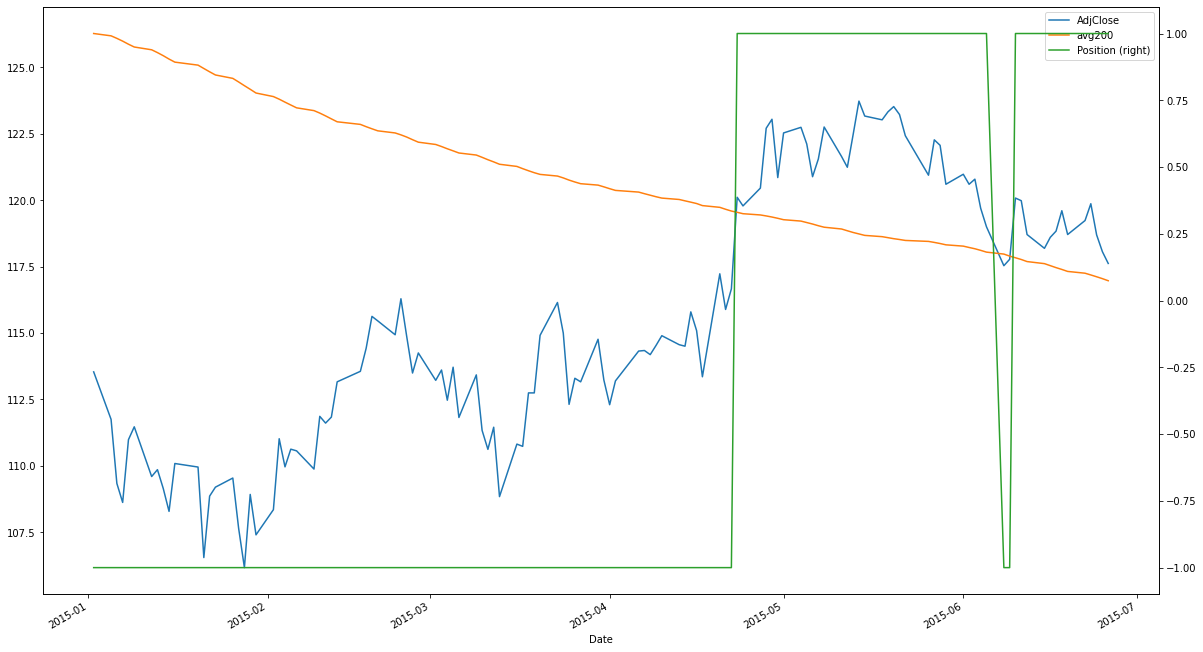

In [ ]:
#plot

dftrain = train[['AdjClose','avg200','Position']]
dftrain1 = dftrain.loc['2015-01-01':]
ax = dftrain1.plot(secondary_y='Position', figsize=(20, 12))
#ax.get_legend().set_bbox_to_anchor((0.25, 0.85));


In [ ]:
train['Strategy'] = train['Position'].shift(1) * train['Log_Returns']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
train["Strategy"]

Date
1999-12-31         NaN
2000-01-03    0.072617
2000-01-04   -0.034534
2000-01-05    0.034534
2000-01-06   -0.017391
                ...   
2015-06-22    0.004421
2015-06-23    0.005292
2015-06-24   -0.009834
2015-06-25   -0.005344
2015-06-26   -0.003740
Name: Strategy, Length: 3896, dtype: float64

In [ ]:
np.exp(train[['Log_Returns', 'Strategy']].sum()) 

Log_Returns    1.903797
Strategy       0.575829
dtype: float64

In [ ]:
train[['Log_Returns', 'Strategy']].std() * 252 ** 0.5

Log_Returns    0.268778
Strategy       0.268781
dtype: float64

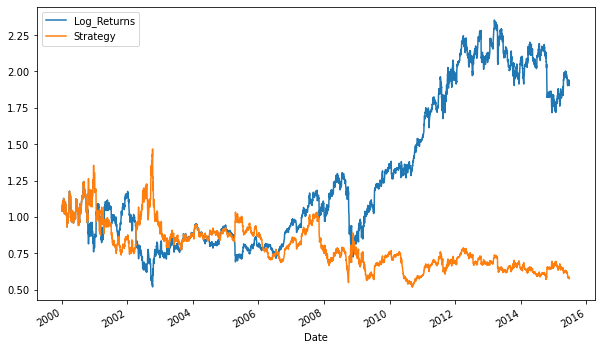

In [ ]:
ax = train[['Log_Returns', 'Strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))
#dftrain1['Position'].plot(ax=ax, secondary_y='Position', style='--')
#ax.get_legend().set_bbox_to_anchor((0.25, 0.85));


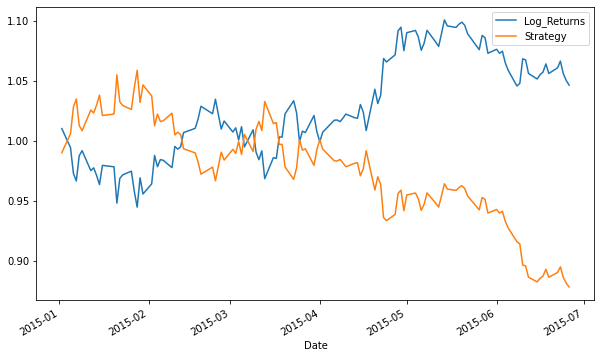

In [ ]:
dftrain = train[['avg10','avg100','Position','Log_Returns', 'Strategy']]
dftrain2 = dftrain.loc['2015-01-01':'2017-09-11']
ax = dftrain2[['Log_Returns', 'Strategy']].cumsum(
).apply(np.exp).plot(figsize=(10, 6))
#dftrain1['Position'].plot(ax=ax, secondary_y='Position', style='--')
#ax.get_legend().set_bbox_to_anchor((0.25, 0.85));


In [ ]:
dftrain1.tail()

,AdjClose,avg200,Position
Date,,,
2015-06-22,119.231102,117.250239,1
2015-06-23,119.863777,117.184339,1
2015-06-24,118.690865,117.116263,1
2015-06-25,118.058235,117.045546,1
2015-06-26,117.617470,116.967232,1


In [ ]:
dftrain.tail()

,avg10,avg100,Position,Log_Returns,Strategy
Date,,,,,
2015-06-22,118.968817,116.407847,1,0.004421,0.004421
2015-06-23,119.177811,116.517195,1,0.005292,0.005292
2015-06-24,119.039194,116.630018,1,-0.009834,-0.009834
2015-06-25,118.847263,116.727056,1,-0.005344,-0.005344
2015-06-26,118.738499,116.792993,1,-0.003740,-0.003740


### NASDAQ

In [ ]:
train_pct_index = int(0.8*len(NASDAQ_final))
train, test = NASDAQ_final[:train_pct_index],NASDAQ_final[train_pct_index:]

train['Log_Returns'] = np.log(train['AdjClose'] / train['AdjClose'].shift(1))

train['Position'] = np.where(train['AdjClose'] > train['avg200'], 1, -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



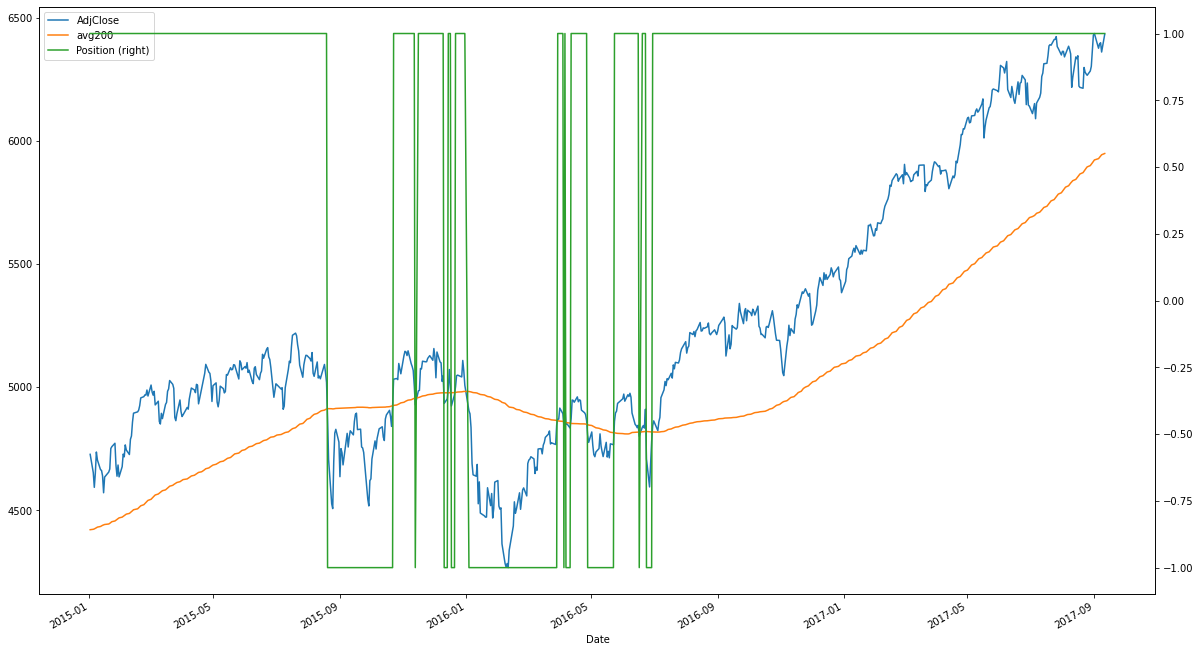

In [ ]:
#plot

dftrain = train[['AdjClose','avg200','Position']]
dftrain1 = dftrain.loc['2015-01-01':]
ax = dftrain1.plot(secondary_y='Position', figsize=(20, 12))

In [ ]:
train['Strategy'] = train['Position'].shift(1) * train['Log_Returns']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



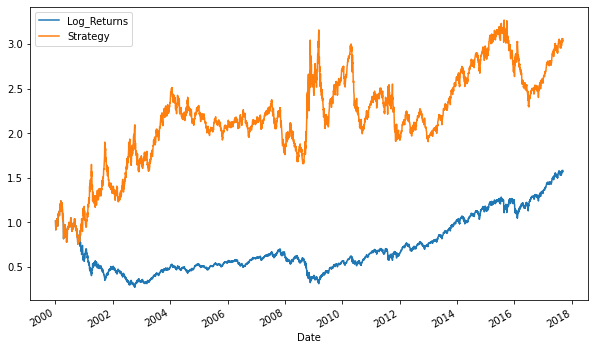

In [ ]:
ax = train[['Log_Returns', 'Strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))

### Gold

In [ ]:
train_pct_index = int(0.8*len(GLD_final))
train, test = GLD_final[:train_pct_index],GLD_final[train_pct_index:]

train['Log_Returns'] = np.log(train['AdjClose'] / train['AdjClose'].shift(1))

train['Position'] = np.where(train['AdjClose'] > train['avg200'], 1, -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



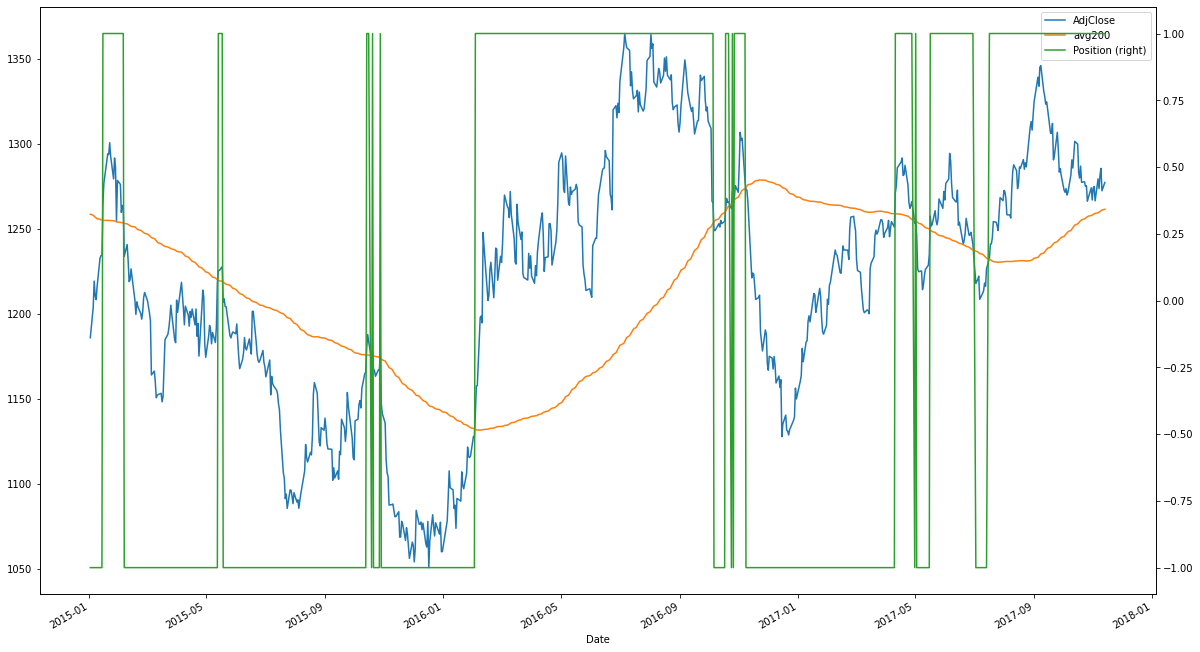

In [ ]:
#plot

dftrain = train[['avg1','avg200','Position']]
dftrain1 = dftrain.loc['2015-01-01':]
ax = dftrain1.plot(secondary_y='Position', figsize=(20, 12))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



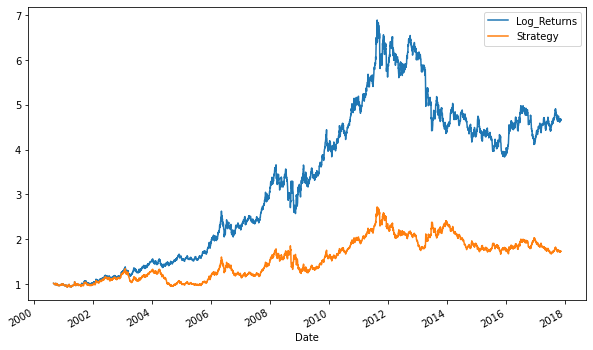

In [ ]:
train['Strategy'] = train['Position'].shift(1) * train['Log_Returns']

ax = train[['Log_Returns', 'Strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))

### WTI

In [ ]:
train_pct_index = int(0.8*len(WTI_final))
train, test = WTI_final[:train_pct_index],WTI_final[train_pct_index:]

train['Log_Returns'] = np.log(train['AdjClose'] / train['AdjClose'].shift(1))

train['Position'] = np.where(train['AdjClose'] > train['avg200'], 1, -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



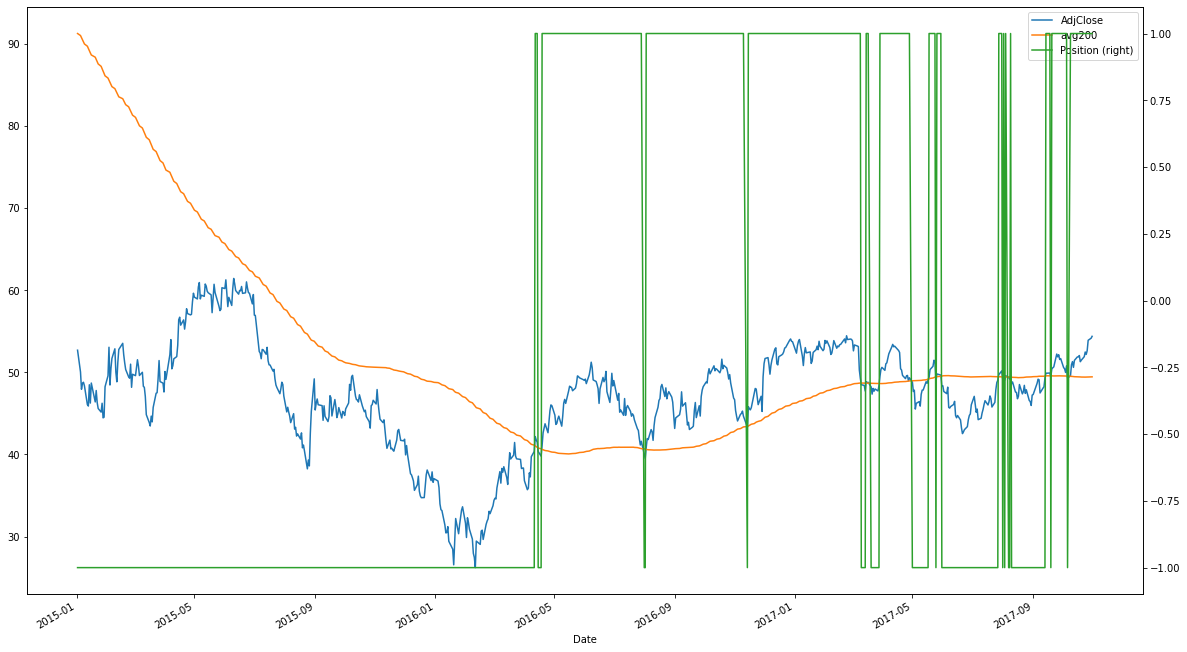

In [ ]:
#plot

dftrain = train[['AdjClose','avg200','Position']]
dftrain1 = dftrain.loc['2015-01-01':]
ax = dftrain1.plot(secondary_y='Position', figsize=(20, 12))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



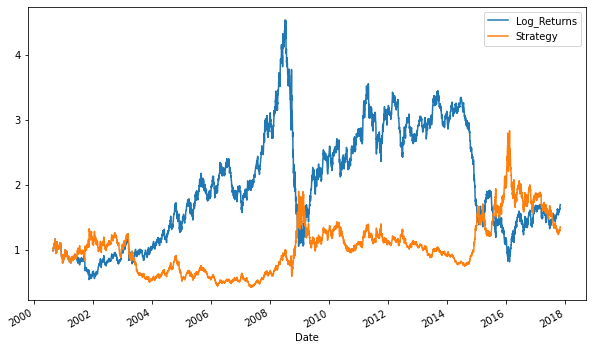

In [ ]:
train['Strategy'] = train['Position'].shift(1) * train['Log_Returns']

ax = train[['Log_Returns', 'Strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))

## Clustering (K-means)

In [ ]:
lags = 2
def create_lags(data):
  global cols
  cols = []
  for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    data[col] = data['Log_Returns'].shift(lag)
    cols.append(col)

### IBM

In [ ]:
#Split train e test

train_pct_index = int(0.8*len(IBM_final))
train, test = IBM_final[:train_pct_index],IBM_final[train_pct_index:]

In [ ]:
train['Log_Returns'] = np.log(train['AdjClose'] / train['AdjClose'].shift(1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
create_lags(train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
cols

['lag_1', 'lag_2']

In [ ]:
train = train.fillna(0)

In [ ]:
model = KMeans(n_clusters=2, random_state=0) 
model.fit(train[cols])
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
n_clusters=2, n_init=10,
random_state=0, tol=0.0001, verbose=0)


KMeans(n_clusters=2, random_state=0)

In [ ]:
train['pos_clus'] = model.predict(train[cols])


In [ ]:
train['pos_clus'] = np.where(train['pos_clus'] == 1, -1, 1) 

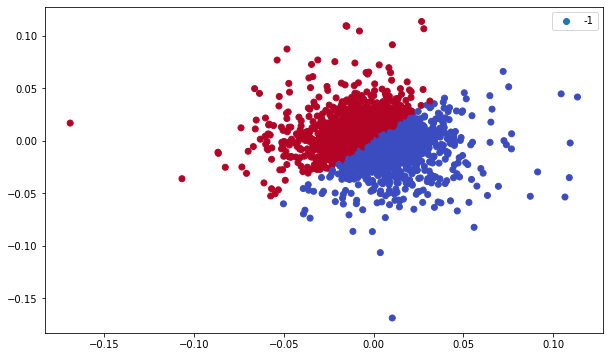

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(train[cols].iloc[:, 0], train[cols].iloc[:, 1],
c=train['pos_clus'], cmap='coolwarm', label = train['pos_clus'])
plt.legend(train['pos_clus'])
plt.show()

In [ ]:
train.head(50)

,AdjClose,Open,High,Low,Close,Volume,avg7,avg10,avg50,avg100,...,SPD_HIGH/LOW,Adj_Close_Returns,Close_Returns,Log_Returns,pos_string,direction,count_pos_string,lag_1,lag_2,pos_clus
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,61.780476,104.385757,104.684509,101.935944,103.130974,3002334,0.000000,0.000000,0.000000,0.0,...,2.748565,0.000000,0.000000,0.000000,0,0,0,0.000000,0.000000,-1
2000-01-03,66.433693,107.492828,110.898659,106.955070,110.898659,10823694,0.000000,0.000000,0.000000,0.0,...,3.943589,7.531857,7.531864,0.072617,1,1,1,0.000000,0.000000,-1
2000-01-04,64.178642,108.986618,109.464630,105.999046,107.134323,8606279,0.000000,0.000000,0.000000,0.0,...,3.465584,-3.394438,-3.394393,-0.034534,0,-1,0,0.072617,0.000000,-1
2000-01-05,66.433693,107.970840,114.483749,107.194077,110.898659,13318927,0.000000,0.000000,0.000000,0.0,...,7.289672,3.513709,3.513660,0.034534,1,1,1,-0.034534,0.072617,1
2000-01-06,65.288307,112.810707,113.706978,108.508606,108.986618,8338607,0.000000,0.000000,0.000000,0.0,...,5.198372,-1.724104,-1.724134,-0.017391,0,-1,0,0.034534,-0.034534,-1
2000-01-07,65.001938,112.093689,112.750954,105.760040,108.508606,12402108,0.000000,0.000000,0.000000,0.0,...,6.990914,-0.438623,-0.438597,-0.004396,0,-1,0,-0.017391,0.034534,1
2000-01-10,67.579079,112.093689,114.125237,110.301147,112.810707,8933363,65.242261,0.000000,0.000000,0.0,...,3.824090,3.964714,3.964756,0.038881,1,1,1,-0.004396,-0.017391,-1
2000-01-11,68.151772,112.691208,115.798279,111.496178,113.766731,8235472,66.152446,0.000000,0.000000,0.0,...,4.302101,0.847441,0.847459,0.008439,1,1,2,0.038881,-0.004396,-1
2000-01-12,68.438156,114.364243,116.634796,113.049713,114.244743,7116775,66.438798,0.000000,0.000000,0.0,...,3.585083,0.420216,0.420169,0.004193,1,1,3,0.008439,0.038881,1


In [ ]:
train['strat_clus'] = train['pos_clus'] * train['Log_Returns']

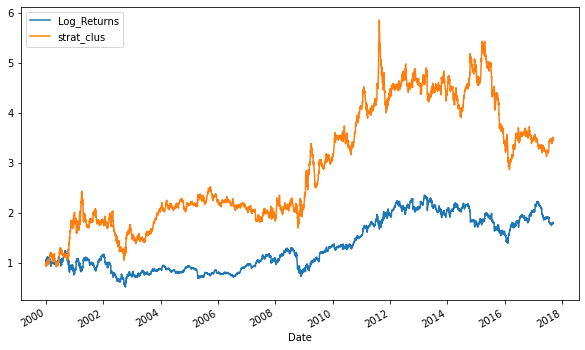

In [ ]:
train[['Log_Returns', 'strat_clus']].cumsum(
).apply(np.exp).plot(figsize=(10, 6));

### NASDAQ

In [ ]:
#Split train e test

train_pct_index = int(0.8*len(NASDAQ_final))
train, test = NASDAQ_final[:train_pct_index],NASDAQ_final[train_pct_index:]

In [ ]:
train['Log_Returns'] = np.log(train['AdjClose'] / train['AdjClose'].shift(1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
create_lags(train)

train = train.fillna(0)

model = KMeans(n_clusters=2, random_state=0) 
model.fit(train[cols])
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
n_clusters=2, n_init=10,
random_state=0, tol=0.0001, verbose=0)

train['pos_clus'] = model.predict(train[cols])

train['pos_clus'] = np.where(train['pos_clus'] == 1, -1, 1) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



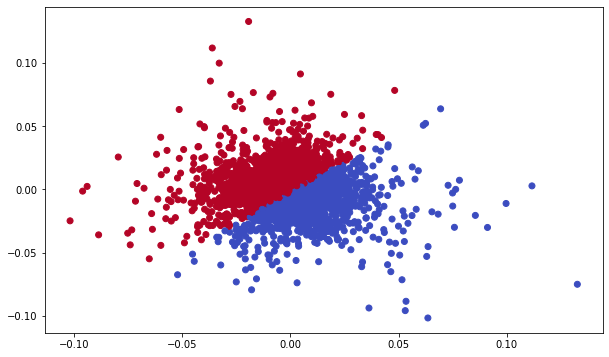

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(train[cols].iloc[:, 0], train[cols].iloc[:, 1],
c=train['pos_clus'], cmap='coolwarm');

In [ ]:
train['strat_clus'] = train['pos_clus'] * train['Log_Returns']

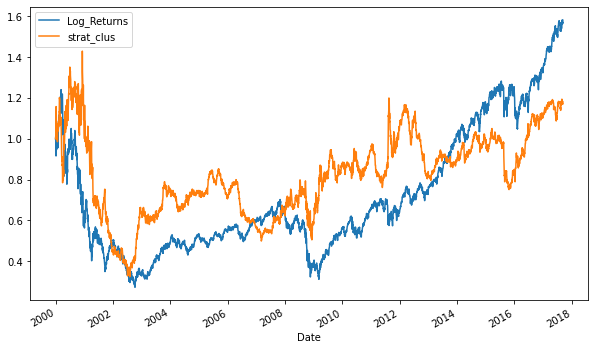

In [ ]:
train[['Log_Returns', 'strat_clus']].cumsum(
).apply(np.exp).plot(figsize=(10, 6));

### Gold

In [ ]:
#Split train e test

train_pct_index = int(0.8*len(GLD_final))
train, test = GLD_final[:train_pct_index],GLD_final[train_pct_index:]

In [ ]:
train['Log_Returns'] = np.log(train['AdjClose'] / train['AdjClose'].shift(1))

create_lags(train)

train = train.fillna(0)

model = KMeans(n_clusters=2, random_state=0) 
model.fit(train[cols])
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
n_clusters=2, n_init=10,
random_state=0, tol=0.0001, verbose=0)

train['pos_clus'] = model.predict(train[cols])

train['pos_clus'] = np.where(train['pos_clus'] == 1, -1, 1) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



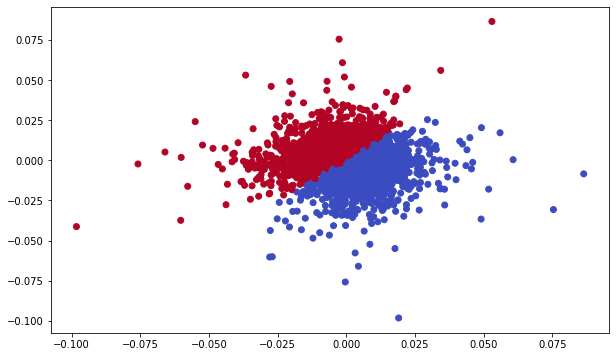

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(train[cols].iloc[:, 0], train[cols].iloc[:, 1],
c=train['pos_clus'], cmap='coolwarm');

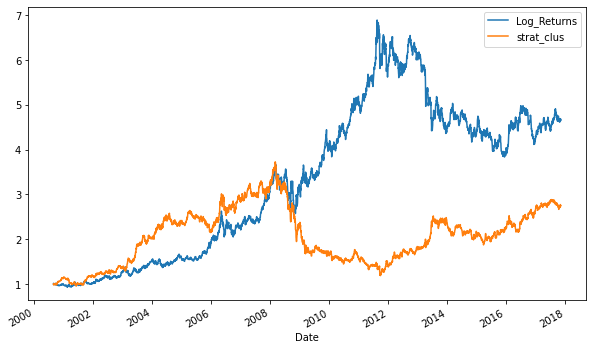

In [ ]:
train['strat_clus'] = train['pos_clus'] * train['Log_Returns']

train[['Log_Returns', 'strat_clus']].cumsum(
).apply(np.exp).plot(figsize=(10, 6));

### WTI

In [ ]:
#Split train e test

train_pct_index = int(0.8*len(WTI_final))
train, test = WTI_final[:train_pct_index],WTI_final[train_pct_index:]

In [ ]:
train['Log_Returns'] = np.log(train['AdjClose'] / train['AdjClose'].shift(1))

create_lags(train)

train = train.fillna(0)

model = KMeans(n_clusters=2, random_state=0) 
model.fit(train[cols])
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
n_clusters=2, n_init=10,
random_state=0, tol=0.0001, verbose=0)

train['pos_clus'] = model.predict(train[cols])

train['pos_clus'] = np.where(train['pos_clus'] == 1, -1, 1) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



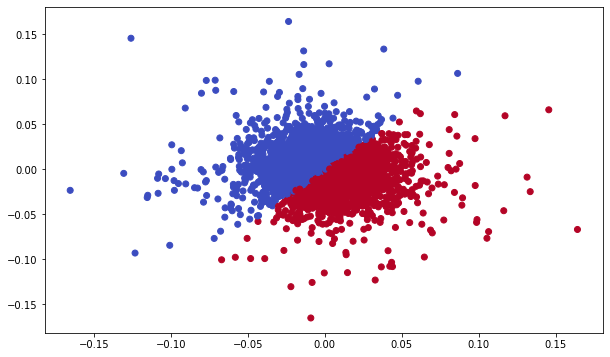

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(train[cols].iloc[:, 0], train[cols].iloc[:, 1],
c=train['pos_clus'], cmap='coolwarm');

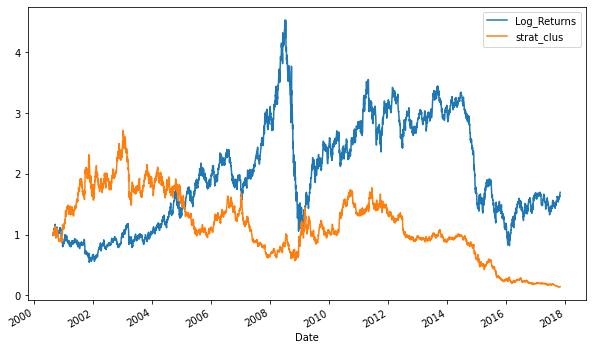

In [ ]:
train['strat_clus'] = train['pos_clus'] * train['Log_Returns']

train[['Log_Returns', 'strat_clus']].cumsum(
).apply(np.exp).plot(figsize=(10, 6));

## COMMANDS FOR **INDICATORS**

**IBM**

In [ ]:
close_IBM = IBM_final["AdjClose"].to_numpy()
open_IBM = IBM_final["Open"].to_numpy()
high_IBM = IBM_final["High"].to_numpy()
low_IBM = IBM_final["High"].to_numpy()
volume_IBM =  IBM_final["Volume"].to_numpy()
time_IBM = IBM["Date"].to_numpy()
true_close_IBM = IBM_final["Close"].to_numpy()


float_close_IBM = [float(x) for x in close_IBM]
close_IBM = np.array(float_close_IBM)

float_true_close_IBM = [float(x) for x in true_close_IBM]
true_close_IBM = np.array(float_true_close_IBM)


float_high_IBM = [float(x) for x in high_IBM]
high_IBM = np.array(float_high_IBM)


float_open_IBM = [float(x) for x in open_IBM]
open_IBM = np.array(float_open_IBM)


float_volume_IBM = [float(x) for x in volume_IBM]
volume_IBM = np.array(float_volume_IBM)


float_low_IBM = [float(x) for x in low_IBM]
low_IBM = np.array(float_low_IBM)

**NASDAQ**

In [ ]:
close_NASDAQ = NASDAQ_final["AdjClose"].to_numpy()
open_NASDAQ = NASDAQ_final["Open"].to_numpy()
high_NASDAQ = NASDAQ_final["High"].to_numpy()
low_NASDAQ = NASDAQ_final["High"].to_numpy()
volume_NASDAQ =  NASDAQ_final["Volume"].to_numpy()
time_NASDAQ = NASDAQ["Date"].to_numpy()
true_close_NASDAQ = NASDAQ_final["Close"].to_numpy()


float_close_NASDAQ = [float(x) for x in close_NASDAQ]
close_NASDAQ = np.array(float_close_NASDAQ)

float_true_close_NASDAQ = [float(x) for x in true_close_NASDAQ]
true_close_NASDAQ = np.array(float_true_close_NASDAQ)

float_high_NASDAQ = [float(x) for x in high_NASDAQ]
high_NASDAQ = np.array(float_high_NASDAQ)


float_open_NASDAQ = [float(x) for x in open_NASDAQ]
open_NASDAQ = np.array(float_open_NASDAQ)


float_volume_NASDAQ = [float(x) for x in volume_NASDAQ]
volume_NASDAQ = np.array(float_volume_NASDAQ)


float_low_NASDAQ = [float(x) for x in low_NASDAQ]
low_NASDAQ = np.array(float_low_NASDAQ)

**GOLD**

In [ ]:
close_GLD = GLD_final["AdjClose"].to_numpy()
open_GLD = GLD_final["Open"].to_numpy()
high_GLD = GLD_final["High"].to_numpy()
low_GLD = GLD_final["High"].to_numpy()
volume_GLD =  GLD_final["Volume"].to_numpy()
time_GLD = GLD["Date"].to_numpy()
true_close_GLD = GLD_final["Close"].to_numpy()

float_close_GLD = [float(x) for x in close_GLD]
close_GLD = np.array(float_close_GLD)

float_true_close_GLD = [float(x) for x in true_close_GLD]
true_close_GLD = np.array(float_true_close_GLD)

float_high_GLD = [float(x) for x in high_GLD]
high_GLD = np.array(float_high_GLD)


float_open_GLD = [float(x) for x in open_GLD]
open_GLD = np.array(float_open_GLD)


float_volume_GLD = [float(x) for x in volume_GLD]
volume_GLD = np.array(float_volume_GLD)


float_low_GLD = [float(x) for x in low_GLD]
low_GLD = np.array(float_low_GLD)

**WTI**

In [ ]:
close_WTI = WTI_final["AdjClose"].to_numpy()
open_WTI = WTI_final["Open"].to_numpy()
high_WTI = WTI_final["High"].to_numpy()
low_WTI = WTI_final["High"].to_numpy()
volume_WTI =  WTI_final["Volume"].to_numpy()
time_WTI = WTI["Date"].to_numpy()
true_close_WTI = WTI_final["Close"].to_numpy()

float_close_WTI = [float(x) for x in close_WTI]
close_WTI = np.array(float_close_WTI)

float_true_close_WTI = [float(x) for x in true_close_WTI]
true_close_WTI = np.array(float_true_close_WTI)

float_high_WTI = [float(x) for x in high_WTI]
high_WTI = np.array(float_high_WTI)


float_open_WTI = [float(x) for x in open_WTI]
open_WTI = np.array(float_open_WTI)


float_volume_WTI = [float(x) for x in volume_WTI]
volume_WTI = np.array(float_volume_WTI)


float_low_WTI = [float(x) for x in low_WTI]
low_WTI = np.array(float_low_WTI)

# MACD - Moving Average Convergence/Divergence

**IBM**

In [ ]:
macd, macdsignal, macdhist = talib.MACD(close_IBM, fastperiod=12, slowperiod=26, signalperiod=9)
IBM_final["macd"] = macd
IBM_final["signal"] = macdsignal
IBM_final["hist"] = macdhist

In [ ]:
mean_macd = IBM_final["macd"].mean()
mean_hist = IBM_final["hist"].mean()
mean_signal = IBM_final["signal"].mean()

IBM_final["macd"]= IBM_final["macd"].fillna(mean_macd)
IBM_final["hist"]= IBM_final["hist"].fillna(mean_hist)
IBM_final["signal"]= IBM_final["signal"].fillna(mean_signal)

MACD_DAILY = []
MACD_9DAY = []

for i in range(len(macd)):
    if macd[i-1] <0 and  macd[i] > 0:
        MACD_DAILY.append(1)
    elif macd[i-1] > 0 and macd[i] < 0:
        MACD_DAILY.append(-1)
    else:
        MACD_DAILY.append(0)
        
IBM_final["MACD_1DAY_strategy"] = MACD_DAILY

for i in range(len(macdsignal)):
    if macdsignal[i-1] <0 and  macdsignal[i] > 0:
        MACD_9DAY.append(1)
    elif macdsignal[i-1] > 0 and macdsignal[i] < 0:
        MACD_9DAY.append(-1)
    else:
        MACD_9DAY.append(0)
        
IBM_final["MACD_9DAY_strategy"] = MACD_9DAY

#SE ENTRAMBE DELLO STESSO SEGNO LA PROBABILITA DI TREND è PIU FORTE

MACD_CONVERGENCE = []

for i in range(len(MACD_DAILY)):
    if MACD_DAILY[i]== -1 and MACD_9DAY[i] == -1:
        MACD_CONVERGENCE.append(-1)
    elif MACD_DAILY[i]== 1 and MACD_9DAY[i] == 1:
        MACD_CONVERGENCE.append(1)
    else:
        MACD_CONVERGENCE.append(0)


IBM_final["MACD_CONVERGENCE_strategy"] = MACD_CONVERGENCE

**NASDAQ**

In [ ]:
macd, macdsignal, macdhist = talib.MACD(close_NASDAQ, fastperiod=12, slowperiod=26, signalperiod=9)
NASDAQ_final["macd"] = macd
NASDAQ_final["signal"] = macdsignal
NASDAQ_final["hist"] = macdhist

In [ ]:
mean_macd = NASDAQ_final["macd"].mean()
mean_hist = NASDAQ_final["hist"].mean()
mean_signal = NASDAQ_final["signal"].mean()

NASDAQ_final["macd"]= NASDAQ_final["macd"].fillna(mean_macd)
NASDAQ_final["hist"]= NASDAQ_final["hist"].fillna(mean_hist)
NASDAQ_final["signal"]= NASDAQ_final["signal"].fillna(mean_signal)

MACD_DAILY = []
MACD_9DAY = []

for i in range(len(macd)):
    if macd[i-1] <0 and  macd[i] > 0:
        MACD_DAILY.append(1)
    elif macd[i-1] > 0 and macd[i] < 0:
        MACD_DAILY.append(-1)
    else:
        MACD_DAILY.append(0)
        
NASDAQ_final["MACD_1DAY_strategy"] = MACD_DAILY

for i in range(len(macdsignal)):
    if macdsignal[i-1] <0 and  macdsignal[i] > 0:
        MACD_9DAY.append(1)
    elif macdsignal[i-1] > 0 and macdsignal[i] < 0:
        MACD_9DAY.append(-1)
    else:
        MACD_9DAY.append(0)
        
NASDAQ_final["MACD_9DAY_strategy"] = MACD_9DAY

#SE ENTRAMBE DELLO STESSO SEGNO LA PROBABILITA DI TREND è PIU FORTE

MACD_CONVERGENCE = []

for i in range(len(MACD_DAILY)):
    if MACD_DAILY[i]== -1 and MACD_9DAY[i] == -1:
        MACD_CONVERGENCE.append(-1)
    elif MACD_DAILY[i]== 1 and MACD_9DAY[i] == 1:
        MACD_CONVERGENCE.append(1)
    else:
        MACD_CONVERGENCE.append(0)


NASDAQ_final["MACD_CONVERGENCE_strategy"] = MACD_CONVERGENCE

**GOLD**

In [ ]:
macd, macdsignal, macdhist = talib.MACD(close_GLD, fastperiod=12, slowperiod=26, signalperiod=9)
GLD_final["macd"] = macd
GLD_final["signal"] = macdsignal
GLD_final["hist"] = macdhist

mean_macd = GLD_final["macd"].mean()
mean_hist = GLD_final["hist"].mean()
mean_signal = GLD_final["signal"].mean()

GLD_final["macd"]= GLD_final["macd"].fillna(mean_macd)
GLD_final["hist"]= GLD_final["hist"].fillna(mean_hist)
GLD_final["signal"]= GLD_final["signal"].fillna(mean_signal)

MACD_DAILY = []
MACD_9DAY = []

for i in range(len(macd)):
    if macd[i-1] <0 and  macd[i] > 0:
        MACD_DAILY.append(1)
    elif macd[i-1] > 0 and macd[i] < 0:
        MACD_DAILY.append(-1)
    else:
        MACD_DAILY.append(0)
        
GLD_final["MACD_1DAY_strategy"] = MACD_DAILY

for i in range(len(macdsignal)):
    if macdsignal[i-1] <0 and  macdsignal[i] > 0:
        MACD_9DAY.append(1)
    elif macdsignal[i-1] > 0 and macdsignal[i] < 0:
        MACD_9DAY.append(-1)
    else:
        MACD_9DAY.append(0)
        
GLD_final["MACD_9DAY_strategy"] = MACD_9DAY

#SE ENTRAMBE DELLO STESSO SEGNO LA PROBABILITA DI TREND è PIU FORTE

MACD_CONVERGENCE = []

for i in range(len(MACD_DAILY)):
    if MACD_DAILY[i]== -1 and MACD_9DAY[i] == -1:
        MACD_CONVERGENCE.append(-1)
    elif MACD_DAILY[i]== 1 and MACD_9DAY[i] == 1:
        MACD_CONVERGENCE.append(1)
    else:
        MACD_CONVERGENCE.append(0)


GLD_final["MACD_CONVERGENCE_strategy"] = MACD_CONVERGENCE


**WTI**

In [ ]:
macd, macdsignal, macdhist = talib.MACD(close_WTI, fastperiod=12, slowperiod=26, signalperiod=9)
WTI_final["macd"] = macd
WTI_final["signal"] = macdsignal
WTI_final["hist"] = macdhist

mean_macd = WTI_final["macd"].mean()
mean_hist = WTI_final["hist"].mean()
mean_signal = WTI_final["signal"].mean()

WTI_final["macd"]= WTI_final["macd"].fillna(mean_macd)
WTI_final["hist"]= WTI_final["hist"].fillna(mean_hist)
WTI_final["signal"]= WTI_final["signal"].fillna(mean_signal)

MACD_DAILY = []
MACD_9DAY = []

for i in range(len(macd)):
    if macd[i-1] <0 and  macd[i] > 0:
        MACD_DAILY.append(1)
    elif macd[i-1] > 0 and macd[i] < 0:
        MACD_DAILY.append(-1)
    else:
        MACD_DAILY.append(0)
        
WTI_final["MACD_1DAY_strategy"] = MACD_DAILY

for i in range(len(macdsignal)):
    if macdsignal[i-1] <0 and  macdsignal[i] > 0:
        MACD_9DAY.append(1)
    elif macdsignal[i-1] > 0 and macdsignal[i] < 0:
        MACD_9DAY.append(-1)
    else:
        MACD_9DAY.append(0)
        
WTI_final["MACD_9DAY_strategy"] = MACD_9DAY

#SE ENTRAMBE DELLO STESSO SEGNO LA PROBABILITA DI TREND è PIU FORTE

MACD_CONVERGENCE = []

for i in range(len(MACD_DAILY)):
    if MACD_DAILY[i]== -1 and MACD_9DAY[i] == -1:
        MACD_CONVERGENCE.append(-1)
    elif MACD_DAILY[i]== 1 and MACD_9DAY[i] == 1:
        MACD_CONVERGENCE.append(1)
    else:
        MACD_CONVERGENCE.append(0)


WTI_final["MACD_CONVERGENCE_strategy"] = MACD_CONVERGENCE

# RSI - Relative Strength Index

**IBM**

In [ ]:
rsi_IBM = talib.RSI(close_IBM, timeperiod=14)
IBM_final["RSI"] = rsi_IBM

mean = IBM_final["RSI"].mean()

IBM_final["RSI"]= IBM_final["RSI"].fillna(mean)

RSI_IBM = []

for i in IBM_final["RSI"]:
    if i > 70:
        RSI_IBM.append(-1)
    elif i> 30 and i< 70:
        RSI_IBM.append(0)
    elif i < 30:
        RSI_IBM.append(1)
  

IBM_final["RSI_strategy"] = RSI_IBM

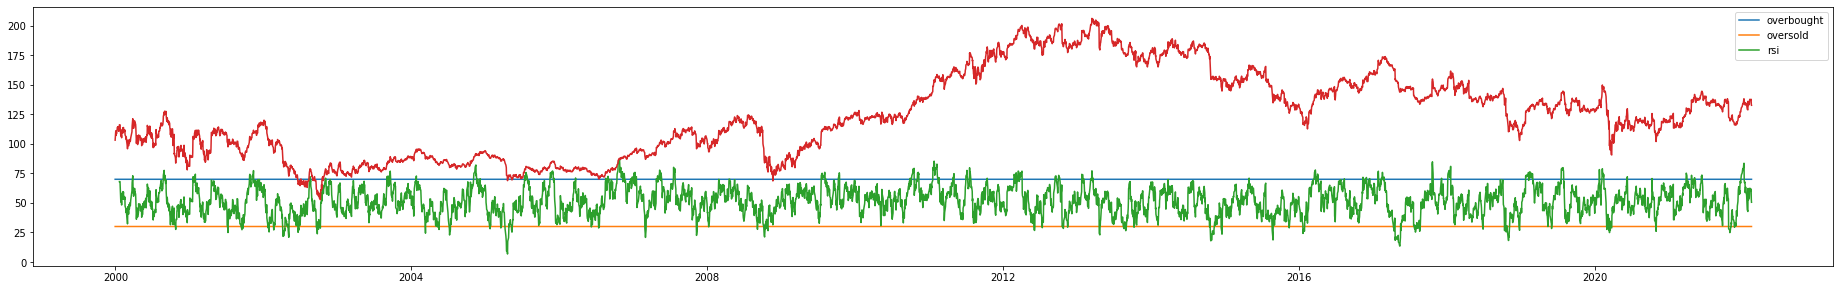

In [ ]:
fig = plt.figure()
fig.set_size_inches((25, 18))
ax_rsi = fig.add_axes((0, 0.24, 1, 0.2))
ax_rsi.plot(IBM_final.index, [70] * len(IBM_final.index), label="overbought")
ax_rsi.plot(IBM_final.index, [30] * len(IBM_final.index), label="oversold")
ax_rsi.plot(IBM_final.index, rsi_IBM, label="rsi")
ax_rsi.plot(IBM_final["Close"])
ax_rsi.legend()

**NASDAQ**

In [ ]:
rsi_NASDAQ = talib.RSI(close_NASDAQ, timeperiod=14)
NASDAQ_final["RSI"] = rsi_NASDAQ

mean = NASDAQ_final["RSI"].mean()

NASDAQ_final["RSI"]= NASDAQ_final["RSI"].fillna(mean)

RSI_NASDAQ = []

for i in NASDAQ_final["RSI"]:
    if i > 70:
        RSI_NASDAQ.append(-1)
    elif i> 30 and i< 70:
        RSI_NASDAQ.append(0)
    elif i < 30:
        RSI_NASDAQ.append(1)
  

NASDAQ_final["RSI_strategy"] = RSI_NASDAQ

**GLD**

In [ ]:
rsi_GLD = talib.RSI(close_GLD, timeperiod=14)
GLD_final["RSI"] = rsi_GLD

mean = GLD_final["RSI"].mean()

GLD_final["RSI"]= GLD_final["RSI"].fillna(mean)

RSI_GLD = []

for i in GLD_final["RSI"]:
    if i > 70:
        RSI_GLD.append(-1)
    elif i> 30 and i< 70:
        RSI_GLD.append(0)
    elif i < 30:
        RSI_GLD.append(1)
  

GLD_final["RSI_strategy"] = RSI_GLD

**WTI**

In [ ]:
rsi_WTI = talib.RSI(close_WTI, timeperiod=14)
WTI_final["RSI"] = rsi_WTI

mean = WTI_final["RSI"].mean()

WTI_final["RSI"]= WTI_final["RSI"].fillna(mean)

RSI_WTI = []

for i in WTI_final["RSI"]:
    if i > 70:
        RSI_WTI.append(-1)
    elif i> 30 and i< 70:
        RSI_WTI.append(0)
    elif i < 30:
        RSI_WTI.append(1)
  

WTI_final["RSI_strategy"] = RSI_WTI

# OBV - On Balance Volume


**IBM**

In [ ]:
IBM_final["OBV"] = talib.OBV(close_IBM, volume_IBM)

In [ ]:
IBM_final['OBV_EMA'] = IBM_final['OBV'].ewm(com=200).mean()

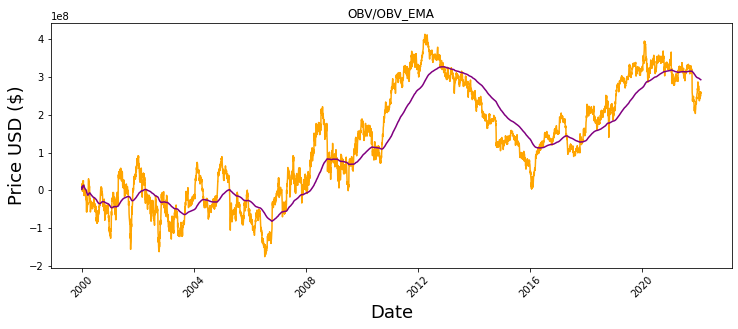

In [ ]:
#Create and plot the graph
plt.figure(figsize=(12.2,4.5)) #width = 12.2in, height = 4.5
#plt.plot( df['Close'],  label='Close')#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)
plt.plot( IBM_final['OBV'],  label='OBV', color= 'orange')
plt.plot( IBM_final['OBV_EMA'],  label='OBV_EMA', color= 'purple')
plt.xticks(rotation=45) 
plt.title('OBV/OBV_EMA')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD ($)',fontsize=18)
plt.show()

In [ ]:
#if OBV > OBV EMA BUY (1) else sell (-1), creare un intervallo medio che rappresenti lo 0

obv = IBM_final["OBV"]
obv_ema = IBM_final["OBV_EMA"]

OBV_strategy= []

for i in range(len(obv)):
    if obv[i] > obv_ema[i]:
        strategy = 1
    else:
        strategy = -1
        
    OBV_strategy.append(strategy)

IBM_final["OBV_strategy"] = OBV_strategy

**NASDAQ**

In [ ]:
NASDAQ_final["OBV"] = talib.OBV(close_NASDAQ, volume_NASDAQ)
NASDAQ_final['OBV_EMA'] = NASDAQ_final['OBV'].ewm(com=200).mean()

#if OBV > OBV EMA BUY (1) else sell (-1), creare un intervallo medio che rappresenti lo 0

obv_NASDAQ = NASDAQ_final["OBV"]
obv_ema_NASDAQ = NASDAQ_final["OBV_EMA"]

OBV_strategy_NASDAQ= []

for i in range(len(obv_NASDAQ)):
    if obv_NASDAQ[i] > obv_ema_NASDAQ[i]:
        strategy = 1
    else:
        strategy = -1
        
    OBV_strategy_NASDAQ.append(strategy)

NASDAQ_final["OBV_strategy"] = OBV_strategy_NASDAQ

**GLD**

In [ ]:
GLD_final["OBV"] = talib.OBV(close_GLD, volume_GLD)
GLD_final['OBV_EMA'] = GLD_final['OBV'].ewm(com=200).mean()

#if OBV > OBV EMA BUY (1) else sell (-1), creare un intervallo medio che rappresenti lo 0

obv_GLD = GLD_final["OBV"]
obv_ema_GLD = GLD_final["OBV_EMA"]

OBV_strategy_GLD= []

for i in range(len(obv_GLD)):
    if obv_GLD[i] > obv_ema_GLD[i]:
        strategy = 1
    else:
        strategy = -1
        
    OBV_strategy_GLD.append(strategy)

GLD_final["OBV_strategy"] = OBV_strategy_GLD

**WTI**

In [ ]:
WTI_final["OBV"] = talib.OBV(close_WTI, volume_WTI)
WTI_final['OBV_EMA'] = WTI_final['OBV'].ewm(com=200).mean()

#if OBV > OBV EMA BUY (1) else sell (-1), creare un intervallo medio che rappresenti lo 0

obv_WTI = WTI_final["OBV"]
obv_ema_WTI = WTI_final["OBV_EMA"]

OBV_strategy_WTI= []

for i in range(len(obv_WTI)):
    if obv_WTI[i] > obv_ema_WTI[i]:
        strategy = 1
    else:
        strategy = -1
        
    OBV_strategy_WTI.append(strategy)

WTI_final["OBV_strategy"] = OBV_strategy_WTI

# TSF - Time Series Forecast


**IBM**

In [ ]:
IBM_final["TSF"] = talib.TSF(close_IBM, timeperiod=14)

mean = IBM_final["TSF"].mean()

IBM_final["TSF"]= IBM_final["TSF"].fillna(mean)

tsf = IBM_final["TSF"]
TSF= []


for i in range(len(tsf)):
    if tsf[i] >  (close_IBM[i]*1.05):
        TSF.append(1)
    elif tsf[i] <  (close_IBM[i]*1.05) and tsf[i] >= (close_IBM[i]*0.95):
        TSF.append(0)
    elif tsf[i] <  (close_IBM[i]*0.95):
        TSF.append(-1)
   
IBM_final["TSF_strategy"] = TSF



**NASDAQ**

In [ ]:
NASDAQ_final["TSF"] = talib.TSF(close_NASDAQ, timeperiod=14)

mean =NASDAQ_final["TSF"].mean()
NASDAQ_final["TSF"]=NASDAQ_final["TSF"].fillna(mean)

tsf =NASDAQ_final["TSF"]
TSF= []


for i in range(len(tsf)):
    if tsf[i] >  (close_NASDAQ[i]*1.05):
        TSF.append(1)
    elif tsf[i] <  (close_NASDAQ[i]*1.05) and tsf[i] >= (close_NASDAQ[i]*0.95):
        TSF.append(0)
    elif tsf[i] <  (close_NASDAQ[i]*0.95):
        TSF.append(-1)

NASDAQ_final["TSF_strategy"] = TSF

**GLD**

In [ ]:
GLD_final["TSF"] = talib.TSF(close_GLD, timeperiod=14)

mean =GLD_final["TSF"].mean()
GLD_final["TSF"]=GLD_final["TSF"].fillna(mean)

tsf =GLD_final["TSF"]
TSF= []


for i in range(len(tsf)):
    if tsf[i] >  (close_GLD[i]*1.05):
        TSF.append(1)
    elif tsf[i] <  (close_GLD[i]*1.05) and tsf[i] >= (close_GLD[i]*0.95):
        TSF.append(0)
    elif tsf[i] <  (close_GLD[i]*0.95):
        TSF.append(-1)

GLD_final["TSF_strategy"] = TSF

**WTI**

In [ ]:
WTI_final["TSF"] = talib.TSF(close_WTI, timeperiod=14)

mean =WTI_final["TSF"].mean()
WTI_final["TSF"]=WTI_final["TSF"].fillna(mean)

tsf =WTI_final["TSF"]
TSF= []


for i in range(len(tsf)):
    if tsf[i] >  (close_WTI[i]*1.05):
        TSF.append(1)
    elif tsf[i] <  (close_WTI[i]*1.05) and tsf[i] >= (close_WTI[i]*0.95):
        TSF.append(0)
    elif tsf[i] <  (close_WTI[i]*0.95):
        TSF.append(-1)

WTI_final["TSF_strategy"] = TSF

# WILLR - Williams' %R

**IBM**

In [ ]:
IBM_final["WILLR"] = talib.WILLR(high_IBM, low_IBM, true_close_IBM, timeperiod=14)

mean = IBM_final["WILLR"].mean()

IBM_final["WILLR"]= IBM_final["WILLR"].fillna(mean)

WILLR = []

for i in IBM_final["WILLR"]:
    if i >= -20:
        WILLR.append(-1)
    elif i> -80 and i< -20:
        WILLR.append(0)
    elif i <= -80:
        WILLR.append(1)

IBM_final["WILLR_strategy"] = WILLR


**NASDAQ**

In [ ]:
NASDAQ_final["WILLR"] = talib.WILLR(high_NASDAQ, low_NASDAQ, true_close_NASDAQ, timeperiod=14)

mean = NASDAQ_final["WILLR"].mean()

NASDAQ_final["WILLR"]= NASDAQ_final["WILLR"].fillna(mean)

WILLR = []

for i in NASDAQ_final["WILLR"]:
    if i >= -20:
        WILLR.append(-1)
    elif i> -80 and i< -20:
        WILLR.append(0)
    elif i <= -80:
        WILLR.append(1)

NASDAQ_final["WILLR_strategy"] = WILLR

**GOLD**

In [ ]:
GLD_final["WILLR"] = talib.WILLR(high_GLD, low_GLD, true_close_GLD, timeperiod=14)

mean = GLD_final["WILLR"].mean()

GLD_final["WILLR"]= GLD_final["WILLR"].fillna(mean)

WILLR = []

for i in GLD_final["WILLR"]:
    if i >= -20:
        WILLR.append(-1)
    elif i> -80 and i< -20:
        WILLR.append(0)
    elif i <= -80:
        WILLR.append(1)

GLD_final["WILLR_strategy"] = WILLR

**WTI**

In [ ]:
WTI_final["WILLR"] = talib.WILLR(high_WTI, low_WTI, true_close_WTI, timeperiod=14)

mean = WTI_final["WILLR"].mean()

WTI_final["WILLR"]= WTI_final["WILLR"].fillna(mean)

WILLR = []

for i in WTI_final["WILLR"]:
    if i >= -20:
        WILLR.append(-1)
    elif i> -80 and i< -20:
        WILLR.append(0)
    elif i <= -80:
        WILLR.append(1)

WTI_final["WILLR_strategy"] = WILLR

# STOCH

**IBM**

In [ ]:
stoch_K, stoch_D = talib.STOCH(high_IBM, low_IBM, true_close_IBM, fastk_period=14, slowk_period=3,  slowd_period=3)
IBM_final["STOCH_K"] = stoch_K
IBM_final["STOCH_D"] = stoch_D

IBM_stoch_k = []
IBM_stoch_d = []

for x in stoch_K:
    if x >= 80:
        IBM_stoch_k.append(-1)
    elif x <= 20:
        IBM_stoch_k.append(1)
    else:
        IBM_stoch_k.append(0)

        
IBM_final["STOCH_K_strategy"] = IBM_stoch_k



for x in stoch_D:
    if x >= 80:
        IBM_stoch_d.append(-1)
    elif x <= 20:
        IBM_stoch_d.append(1)
    else:
        IBM_stoch_d.append(0)

        
IBM_final["STOCH_D_strategy"] = IBM_stoch_d

        

**NASDAQ**

In [ ]:
stoch_K, stoch_D = talib.STOCH(high_NASDAQ, low_NASDAQ, true_close_NASDAQ, fastk_period=14, slowk_period=3,  slowd_period=3)
NASDAQ_final["STOCH_K"] = stoch_K
NASDAQ_final["STOCH_D"] = stoch_D

NASDAQ_stoch_k = []
NASDAQ_stoch_d = []

for x in stoch_K:
    if x >= 80:
        NASDAQ_stoch_k.append(-1)
    elif x <= 20:
        NASDAQ_stoch_k.append(1)
    else:
        NASDAQ_stoch_k.append(0)

        
NASDAQ_final["STOCH_K_strategy"] = NASDAQ_stoch_k



for x in stoch_D:
    if x >= 80:
        NASDAQ_stoch_d.append(-1)
    elif x <= 20:
        NASDAQ_stoch_d.append(1)
    else:
        NASDAQ_stoch_d.append(0)

        
NASDAQ_final["STOCH_D_strategy"] = NASDAQ_stoch_d

        

**GOLD**

In [ ]:
stoch_K, stoch_D = talib.STOCH(high_GLD, low_GLD, true_close_GLD, fastk_period=14, slowk_period=3,  slowd_period=3)
GLD_final["STOCH_K"] = stoch_K
GLD_final["STOCH_D"] = stoch_D

GLD_stoch_k = []
GLD_stoch_d = []

for x in stoch_K:
    if x >= 80:
        GLD_stoch_k.append(-1)
    elif x <= 20:
        GLD_stoch_k.append(1)
    else:
        GLD_stoch_k.append(0)

        
GLD_final["STOCH_K_strategy"] = GLD_stoch_k



for x in stoch_D:
    if x >= 80:
        GLD_stoch_d.append(-1)
    elif x <= 20:
        GLD_stoch_d.append(1)
    else:
        GLD_stoch_d.append(0)

        
GLD_final["STOCH_D_strategy"] = GLD_stoch_d

        

**WTI**

In [ ]:
stoch_K, stoch_D = talib.STOCH(high_WTI, low_WTI, true_close_WTI, fastk_period=14, slowk_period=3,  slowd_period=3)
WTI_final["STOCH_K"] = stoch_K
WTI_final["STOCH_D"] = stoch_D

WTI_stoch_k = []
WTI_stoch_d = []

for x in stoch_K:
    if x >= 80:
        WTI_stoch_k.append(-1)
    elif x <= 20:
        WTI_stoch_k.append(1)
    else:
        WTI_stoch_k.append(0)

        
WTI_final["STOCH_K_strategy"] = WTI_stoch_k



for x in stoch_D:
    if x >= 80:
        WTI_stoch_d.append(-1)
    elif x <= 20:
        WTI_stoch_d.append(1)
    else:
        WTI_stoch_d.append(0)

        
WTI_final["STOCH_D_strategy"] = WTI_stoch_d

        

# EMA & TEMA

**IBM**

In [ ]:
IBM_final["EMA"] = IBM_final.AdjClose.ewm(span = 3, min_periods =0, adjust= True, ignore_na = False).mean()
IBM_final["TEMA"] = (3* IBM_final.EMA - 3 * IBM_final.EMA * IBM_final.EMA) + (IBM_final.EMA * IBM_final.EMA* IBM_final.EMA)

**NASDAQ**

In [ ]:
NASDAQ_final["EMA"] = NASDAQ_final.AdjClose.ewm(span = 3, min_periods =0, adjust= True, ignore_na = False).mean()
NASDAQ_final["TEMA"] = (3* NASDAQ_final.EMA - 3 * NASDAQ_final.EMA * NASDAQ_final.EMA) + (NASDAQ_final.EMA * NASDAQ_final.EMA* NASDAQ_final.EMA)

**WTI**

In [ ]:
WTI_final["EMA"] = WTI_final.AdjClose.ewm(span = 3, min_periods =0, adjust= True, ignore_na = False).mean()
WTI_final["TEMA"] = (3* WTI_final.EMA - 3 * WTI_final.EMA * WTI_final.EMA) + (WTI_final.EMA * WTI_final.EMA* WTI_final.EMA)

**GOLD**

In [ ]:
GLD_final["EMA"] = GLD_final.AdjClose.ewm(span = 3, min_periods =0, adjust= True, ignore_na = False).mean()
GLD_final["TEMA"] = (3* GLD_final.EMA - 3 * GLD_final.EMA * GLD_final.EMA) + (GLD_final.EMA * GLD_final.EMA* GLD_final.EMA)

# BOLLINGER WINDOW 21G STD 2

**IBM**

In [ ]:
upperband, middleband, lowerband = talib.BBANDS(close_IBM, timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)
IBM_final["upperband"] = upperband
IBM_final["middleband"] = middleband
IBM_final["lowerband"] = lowerband

**NASDAQ**

In [ ]:
upperband, middleband, lowerband = talib.BBANDS(close_NASDAQ, timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)
NASDAQ_final["upperband"] = upperband
NASDAQ_final["middleband"] = middleband
NASDAQ_final["lowerband"] = lowerband

**WTI**

In [ ]:
upperband, middleband, lowerband = talib.BBANDS(close_WTI, timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)
WTI_final["upperband"] = upperband
WTI_final["middleband"] = middleband
WTI_final["lowerband"] = lowerband

**GOLD**

In [ ]:
upperband, middleband, lowerband = talib.BBANDS(close_GLD, timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)
GLD_final["upperband"] = upperband
GLD_final["middleband"] = middleband
GLD_final["lowerband"] = lowerband

# **MOM**

In [ ]:
IBM_final["MOM"] = IBM_final.AdjClose - 1
NASDAQ_final["MOM"] = NASDAQ_final.AdjClose - 1
WTI_final["MOM"] = WTI_final.AdjClose - 1
GLD_final["MOM"] = GLD_final.AdjClose - 1


# STOCH D(window = 4), K(window = 3)

In [ ]:
def stok(df, n):
    df["stok"] = ((df["Close"] - df["Low"].rolling(window = n, center = False).mean()) /
                  (df["High"].rolling(window = n, center = False).max() -
                  df["Low"].rolling(window = n, center = False).min())) *100
    df["stod"] = df["stok"].rolling(window = 3, center = False).mean()

In [ ]:
stok(IBM_final, 4)
IBM_final = IBM_final.fillna(0)

stok(NASDAQ_final, 4)
NASDAQ_final = NASDAQ_final.fillna(0)

stok(WTI_final, 4)
WTI_final = WTI_final.fillna(0)

stok(GLD_final, 4)
GLD_final = GLD_final.fillna(0)

**ROC**

In [ ]:
IBM_final["ROC"] = talib.ROC(close_IBM, timeperiod = 12)
NASDAQ["ROC"] = talib.ROC(close_NASDAQ, timeperiod = 12)
WTI["ROC"] = talib.ROC(close_WTI, timeperiod = 12)
GLD["ROC"] = talib.ROC(close_GLD, timeperiod = 12)

**CCI**

In [ ]:
IBM_final["CCI"] = talib.CCI(high_IBM, low_IBM, true_close_IBM, timeperiod=20)
NASDAQ_final["CCI"] = talib.CCI(high_NASDAQ, low_NASDAQ, true_close_NASDAQ, timeperiod=20)
WTI_final["CCI"] = talib.CCI(high_WTI, low_WTI, true_close_WTI, timeperiod=20)
GLD_final["CCI"] = talib.CCI(high_GLD, low_GLD, true_close_GLD, timeperiod=20)



#EXCEL FINALE


In [ ]:
IBM_final.to_excel('IBM_final.xlsx')
NASDAQ_final.to_excel('NASDAQ_final.xlsx')
GLD_final.to_excel('GDL_final.xlsx')
WTI_final.to_excel('WTI_final.xlsx')

# STRATEGY

**IBM**


In [ ]:
df_IBM = IBM_final[["Close", "MACD_1DAY_strategy", "MACD_9DAY_strategy", "MACD_CONVERGENCE_strategy","RSI_strategy", "TSF_strategy", "OBV_strategy"  ]]


def buy_sell(signal, col1, col2, col3, col4, col5):
  sigPriceBuy = []
  sigPriceSell = []
  #Loop through the length of the data set
  for i in range(0,len(signal)):
 

    if signal[col1][i] == 1:
      
            sigPriceBuy.append(signal['Close'][i])
            sigPriceSell.append(np.nan)

    
    elif signal[col2][i] == 1:    
         
            sigPriceSell.append(np.nan)
            sigPriceBuy.append(signal['Close'][i])
        
        
    elif signal[col3][i] == 1:   
        
            sigPriceSell.append(np.nan)
            sigPriceBuy.append(signal['Close'][i])
        
    
    elif signal[col4][i] == 1:   

            sigPriceSell.append(np.nan)
            sigPriceBuy.append(signal['Close'][i])
        
        
    elif signal[col5][i] == 1:    
            sigPriceSell.append(np.nan)
            sigPriceBuy.append(signal['Close'][i])
        

    elif signal[col1][i] == -1:   
            sigPriceSell.append(signal['Close'][i])
            sigPriceBuy.append(np.nan)
    
    
    elif signal[col2][i] == -1:    
            sigPriceSell.append(signal['Close'][i])
            sigPriceBuy.append(np.nan)
        
    
    
    elif signal[col3][i] == -1:    
            sigPriceSell.append(signal['Close'][i])
            sigPriceBuy.append(np.nan)
        
    
    elif signal[col4][i] == -1:    
            sigPriceSell.append(signal['Close'][i])
            sigPriceBuy.append(np.nan)
        
    
    
    elif signal[col5][i] == -1:
            sigPriceSell.append(signal['Close'][i])
            sigPriceBuy.append(np.nan)
        
        
      
    else: 
            sigPriceBuy.append(np.nan)
            sigPriceSell.append(np.nan)
  
  return (sigPriceBuy, sigPriceSell)

In [ ]:
#Create buy and sell columns
x = buy_sell(df_IBM, 'MACD_1DAY_strategy','MACD_9DAY_strategy', "MACD_CONVERGENCE_strategy", "RSI_strategy", "TSF_strategy" )
df_IBM['Buy_Signal_Price'] = x[0]
df_IBM['Sell_Signal_Price'] = x[1]

buy_IBM = df_IBM["Buy_Signal_Price"].sum()
sell_IBM = df_IBM["Sell_Signal_Price"].sum()
profit_IBM = sell_IBM - buy_IBM

profit_IBM

In [ ]:
df_IBM

In [ ]:
IBM_final
IBM_final.to_excel('IBM final.xlsx')

#Data visualization strategy MACD/RSI/OBV/TSF

## IBM

### MACD

In [ ]:
#Split train e test

train_pct_index = int(0.8*len(IBM_final))
train, test = IBM_final[:train_pct_index],IBM_final[train_pct_index:]

train['Log_Returns'] = np.log(train['Close'] / train['Close'].shift(1))

In [ ]:
train['MACD_strategy_1d'] = train['MACD_1DAY_strategy'] * train['Log_Returns']

train[['Log_Returns', 'MACD_strategy']].cumsum(
).apply(np.exp).plot(figsize=(10, 6));

In [ ]:
train['MACD_strategy_9d'] = train['MACD_9DAY_strategy'] * train['Log_Returns']

train[['Log_Returns', 'MACD_strategy_9d']].cumsum(
).apply(np.exp).plot(figsize=(10, 6));

In [ ]:
train['MACD_strategy_convergence'] = train['MACD_CONVERGENCE_strategy'] * train['Log_Returns']

train[['Log_Returns', 'MACD_strategy_convergence']].cumsum(
).apply(np.exp).plot(figsize=(10, 6));

###RSI

In [ ]:
train['RSI_strategyxplot'] = train['RSI_strategy'] * train['Log_Returns']

train[['Log_Returns', 'RSI_strategyxplot']].cumsum(
).apply(np.exp).plot(figsize=(10, 6));

### OBV

In [ ]:
train['OBV_strategyxplot'] = train['OBV_strategy'] * train['Log_Returns']

train[['Log_Returns', 'OBV_strategyxplot']].cumsum(
).apply(np.exp).plot(figsize=(10, 6));

### TSF

In [ ]:
train['TSF_strategyxplot'] = train['TSF_strategy'] * train['Log_Returns']

train[['Log_Returns', 'TSF_strategyxplot']].cumsum(
).apply(np.exp).plot(figsize=(10, 6));